In [4]:
import ftplib
import os
import pandas as pd
import youtokentome as yttm
from functools import partial
import gzip
from BCBio import GFF 
import numpy as np
import smart_open 
import gensim 
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt 
import sqlite3
# import sqlalchemy 
from matplotlib import cm
from tables import * 
import torch
# import horovod.torch as hvd
import jupyter_beeper
beep = jupyter_beeper.Beeper()

# hvd.init()
model_path = "/gpfs/data/johnsonslab/nlp-genomics/pasolli-2019/metagenomes_8192k.model"
# model_path = "/gpfs/data/johnsonslab/nlp-genomics/pasolli-2019/metagenomes_1000bp_8192.model"

bpe = yttm.BPE(model=model_path)

beep.beep(secs=1)

In [2]:
import torch
!nvidia-smi
for rank in range(4):
    print(f'{rank}, max memory alloc: {torch.cuda.max_memory_allocated(device=rank)}')


Mon Nov  6 16:51:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  On   | 00000000:17:00.0 Off |                    0 |
| N/A   43C    P0    54W / 300W |      0MiB / 81920MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  On   | 00000000:65:00.0 Off |                    0 |
| N/A   

In [2]:
import os
import sys
print(os.path.dirname(sys.executable))
print(os.environ["CONDA_PREFIX"])
import torch
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())
print(torch.__file__)


/gpfs/home/jic286/.conda/envs/new_new_torch/bin
/gpfs/home/jic286/.conda/envs/new_new_torch
2.1.0+cu121
12.1
True
/gpfs/home/jic286/.conda/envs/new_new_torch/lib/python3.10/site-packages/torch/__init__.py


In [21]:
def retrieve_genomes(path, gzipped=False):
    if(gzipped):
        with gzip.open(path, 'r') as f:
            file_content = f.readlines()
            file_content = [content.strip() for content in file_content]
            
    else:
        with open(path, 'r') as f:
            file_content = f.readlines()
            file_content = [content.strip() for content in file_content]
    if isinstance(file_content[0], bytes):
        file_content = [line.decode('utf') for line in file_content]
    genomes = {}
    bases = ""
    header = file_content[0]
    
    for i in range(1, len(file_content)):
        if(">") in file_content[i]:
            genomes[header] = bases
            header = file_content[i]
            bases=""
        else:
            bases+= file_content[i] 
            if(i==len(file_content)-1):
                genomes[header] = bases
                header = file_content[i]
                bases=""
    return genomes

def retrieve_genome_from_gff(in_file):
    with(open(in_file)) as in_handle:
        return "".join([str(rec.seq) for rec in GFF.parse(in_handle)])
    
def retrieve_genome_from_genome_name(name):
    with(open(os.path.join('/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/gffs/',name + '.gff'))) as in_handle:
        return "".join([str(rec.seq) for rec in GFF.parse(in_handle)])

def write_seq_from_gff(name, path):
    genome = retrieve_genome_from_genome_name(name)
    with (open(os.path.join(path, name +'.txt'), 'w' )) as f:
        f.write(genome)
def read_seq_from_txt(name, path):
    with open(os.path.join(path, name + '.txt'), 'r') as f:
        for line in f:
            return line
    
def tokenize_with_length_threshold(string, length_threshold=100):
    tokens= bpe.encode(string, output_type =yttm.OutputType.SUBWORD )
    out = []
    for token in tokens:
        if(len(token)>=length_threshold):
            out.append(token)
    if(len(out)==0):
        out.append("none")
#     print(len(tokens), len(out))
    return out


def get_clades(filename, df):
    idx = filename[:-4]
    lineage = df.loc[idx].Lineage
    domain = lineage[lineage.find('d__')+3:lineage.find(';')]
    phylum_start_idx = lineage.find('p__')+3
    phylum_end_idx = lineage[phylum_start_idx:].find(';')+phylum_start_idx
    phylum = lineage[phylum_start_idx:phylum_end_idx]
    class_start_idx = lineage.find('c__')+3
    class_end_idx = lineage[class_start_idx:].find(';')+class_start_idx
    class_ = lineage[class_start_idx:class_end_idx] #named so as not to break python
    order_start_idx = lineage.find('o__')+3
    order_end_idx = lineage[order_start_idx:].find(';')+order_start_idx
    order = lineage[order_start_idx:order_end_idx]
    family_start_idx = lineage.find('f__')+3
    family_end_idx = lineage[family_start_idx:].find(';')+family_start_idx
    family = lineage[family_start_idx:family_end_idx]
    genus_start_idx = lineage.find('g__')+3
    genus_end_idx = lineage[genus_start_idx:].find(';')+genus_start_idx
    genus = lineage[genus_start_idx:genus_end_idx]
    species = get_name_from_file(filename, df)
    return domain, phylum, class_, order, family, genus, species


    return domain, phylum
def get_name_from_file(filename, df):
    idx = filename[:-4]
    lineage = df.loc[idx].Lineage
    if(lineage.rfind(" ")==-1):
        genus_start_idx = lineage.find('g__')+3
        genus_end_idx = lineage[genus_start_idx:].find(';')+genus_start_idx
        genus = lineage[genus_start_idx:genus_end_idx]

        return genus + " " + '[none]'
    name = lineage[lineage.find('s__')+3:lineage.find('s__')+4] + "." + lineage[lineage.rfind(" "):]
    return name
def get_species_status(filename, df):
    if(filename[:-4] not in df.index):
        return False
    name = get_name_from_file(filename, df)
    if(name=="._"):
        return False
    else:
        return True
    


### Load metadata

In [8]:
path = '/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/'

# %cd /gpfs/data/johnsonslab/nlp-genomics/almeida-2020
os.chdir(path)
# print(os.getcwd())
df = pd.read_csv(os.path.join(path, 'genomes-all_metadata.tsv'), sep='\t', index_col=0)
print(len(df))
df.head()


289232


,Genome_type,Length,N_contigs,N50,GC_content,Completeness,Contamination,rRNA_5S,rRNA_16S,rRNA_23S,tRNAs,Genome_accession,Species_rep,Lineage,Sample_accession,Study_accession,Country,Continent,FTP_download
Genome,,,,,,,,,,,,,,,,,,,
MGYG000000001,Isolate,3219617,137,47258,28.26,98.59,0.70,88.24,99.74,99.83,20,GUT_GENOME000001,MGYG000000001,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__P...,ERS370061,ERP105624,United Kingdom,Europe,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics...
MGYG000000002,Isolate,4433109,101,109267,42.60,99.37,0.00,82.35,95.37,86.19,19,GUT_GENOME000004,MGYG000000002,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__L...,ERS370064,ERP105624,United Kingdom,Europe,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics...
MGYG000000003,Isolate,3229518,35,158570,58.52,100.00,0.00,94.96,99.67,99.66,20,GUT_GENOME000008,MGYG000000003,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...,ERS370070,ERP105624,United Kingdom,Europe,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics...
MGYG000000004,Isolate,3698896,105,90297,54.19,98.66,0.22,93.28,99.67,99.83,20,GUT_GENOME000010,MGYG000000004,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__O...,ERS370072,ERP105624,United Kingdom,Europe,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics...
MGYG000000005,Isolate,3930428,32,350032,28.59,99.30,0.00,89.08,99.67,99.83,20,GUT_GENOME000017,MGYG000000005,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__P...,ERS417217,ERP105624,United Kingdom,Europe,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics...


In [ ]:
##Old code for testing whether or not a file is missing from the dataset
# %%time
# gffs_path = '/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/gffs/'
# gffs_list = os.listdir(gffs_path)
# missing = []
# for i, genome in enumerate(df.index):
#     if(genome + '.gff' not in gffs_list):
#         print(i, genome)
#         missing.append(genome)
# print(len(missing))

In [12]:
%%time
#Get count of all families 
domains = []
all_domains = []
phyla = []
all_phyla = []
classes = []
all_classes = []
orders = []
all_orders = []
families = []
all_families = []
genera = []
all_genera = []
species_names = []
all_species = []
filenames = []
all_filenames = []
for name in df.index:
    filename = name + '.gff'
    domain, phylum, class_, order, family, genus, species = get_clades(filename, df)
    species_name = get_name_from_file(filename, df)
    if(species_name not in species_names):
        domains.append(domain)
        phyla.append(phylum)
        classes.append(class_)
        orders.append(order)
        families.append(family)
        filenames.append(filename)
        
        genera.append(genus)
        species_names.append(species_name)
    all_domains.append(domain)
    all_phyla.append(phylum)
    all_classes.append(class_)
    all_orders.append(order)
    all_families.append(family)
    all_genera.append(genus)
    all_species.append(species)
    all_filenames.append(filename)
unique_families = set(families)
unique_genera = set(genera)
print(len(unique_families), "unique families,", len(unique_genera), "unique genera")
families_df = pd.Series(families)
print("Non-redundant families: ", len(families), ", all families: ", len(all_families))
family_counts = families_df.value_counts()
family_counts[:10]

202 unique families, 1008 unique genera
Non-redundant families:  3791 , all families:  289232
CPU times: user 3min 52s, sys: 1.02 s, total: 3min 53s
Wall time: 4min 23s


In [13]:
path = '/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/'
all_species_clades = pd.DataFrame({'file':all_filenames, "domain":all_domains,
                                  "phylum":all_phyla, "class":all_classes,
                                  "order":all_orders, "family":all_families,
                                  "genus":all_genera, "species":all_species})
all_species_clades.to_csv(os.path.join(path, 'all_species_clades.csv'), index=False)

In [14]:
all_species_clades

,file,domain,phylum,class,order,family,genus,species
0,MGYG000000001.gff,Bacteria,Firmicutes_A,Clostridia,Peptostreptococcales,Peptostreptococcaceae,GCA-900066495,G. sp902362365
1,MGYG000000002.gff,Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,Blautia_A,B. faecis
2,MGYG000000003.gff,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Rikenellaceae,Alistipes,A. shahii
3,MGYG000000004.gff,Bacteria,Firmicutes_A,Clostridia,Oscillospirales,Ruminococcaceae,Anaerotruncus,A. colihominis
4,MGYG000000005.gff,Bacteria,Firmicutes_A,Clostridia,Peptostreptococcales,Peptostreptococcaceae,Terrisporobacter,T. glycolicus_A
...,...,...,...,...,...,...,...,...
289227,MGYG000289389.gff,Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,AM51-8,A. sp003478275
289228,MGYG000289390.gff,Bacteria,Firmicutes_C,Negativicutes,Acidaminococcales,Acidaminococcaceae,Phascolarctobacterium,P. sp000436095
289229,MGYG000289391.gff,Bacteria,Firmicutes_A,Clostridia,Oscillospirales,Acutalibacteraceae,CAG-488,C. sp000434055
289230,MGYG000289392.gff,Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,Butyrivibrio_A,B. crossotus


In [ ]:
##Threshold to non-redundant families with 
family_counts_over_100 = family_counts[family_counts>100]
print((family_counts_over_100))
len(family_counts_over_100)

In [ ]:
unique_species = pd.DataFrame({"file":filenames, "domain": domains, 
                               "phylum":phyla,"class":classes, 
                               "order":orders, "family":families, 
                               "genus":genera, "species name":species_names})
unique_species.to_csv("unique_species.csv", index=False)


In [5]:
path = '/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/'

unique_species = pd.read_csv(os.path.join(path, "unique_species.csv"), index_col=0)
family_counts = unique_species['family'].value_counts()
family_counts[:10]


Lachnospiraceae       436
Coriobacteriaceae     281
Bacteroidaceae        226
Oscillospiraceae      192
Acutalibacteraceae    181
Ruminococcaceae       140
UBA660                122
Enterobacteriaceae    112
Muribaculaceae         95
CAG-508                83
Name: family, dtype: int64

In [3]:
#Testing on larger dataset - WARNING: MIGHT TAKE YONKS
path = '/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/'

# %cd /gpfs/data/johnsonslab/nlp-genomics/almeida-2020
os.chdir(path)
# print(os.getcwd())
df = pd.read_csv(os.path.join(path, 'genomes-all_metadata.tsv'), sep='\t', index_col=0)


In [15]:
path = '/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/'

df = pd.read_csv(os.path.join(path, 'all_species_clades.csv'), index_col=0)
df

,domain,phylum,class,order,family,genus,species
file,,,,,,,
MGYG000000001.gff,Bacteria,Firmicutes_A,Clostridia,Peptostreptococcales,Peptostreptococcaceae,GCA-900066495,G. sp902362365
MGYG000000002.gff,Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,Blautia_A,B. faecis
MGYG000000003.gff,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Rikenellaceae,Alistipes,A. shahii
MGYG000000004.gff,Bacteria,Firmicutes_A,Clostridia,Oscillospirales,Ruminococcaceae,Anaerotruncus,A. colihominis
MGYG000000005.gff,Bacteria,Firmicutes_A,Clostridia,Peptostreptococcales,Peptostreptococcaceae,Terrisporobacter,T. glycolicus_A
...,...,...,...,...,...,...,...
MGYG000289389.gff,Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,AM51-8,A. sp003478275
MGYG000289390.gff,Bacteria,Firmicutes_C,Negativicutes,Acidaminococcales,Acidaminococcaceae,Phascolarctobacterium,P. sp000436095
MGYG000289391.gff,Bacteria,Firmicutes_A,Clostridia,Oscillospirales,Acutalibacteraceae,CAG-488,C. sp000434055


In [3]:
import os
import pandas as pd
import youtokentome as yttm
from BCBio import GFF

def retrieve_genome_from_gff(in_file):
    with(open(in_file)) as in_handle:
        return "".join([str(rec.seq) for rec in GFF.parse(in_handle)])

model_path = "/gpfs/data/johnsonslab/nlp-genomics/pasolli-2019/metagenomes_8192k.model"
bpe = yttm.BPE(model=model_path)
path = '/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/'
all_species = pd.read_csv(os.path.join(path, "all_species_clades.csv"), index_col=0)
tokenizations = []

print("starting loop")
for filename in all_species.index:
    seq = retrieve_genome_from_gff(os.path.join(path, 'gffs', filename))
    tokens = bpe.encode(seq)
    tokenizations.append(tokens)

tokenization_series = pd.Series(tokenizations_list, index=self.df.index)
all_species['tokens'] = tokenization_series
all_species.to_csv(os.path.join(self.path, 'all_species_clades_tokens_8192k.csv'))


starting loop


KeyboardInterrupt: 

# Deep learning

### Dataloader

In [13]:
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from multiprocessing import Pool


class UHGGDataset(Dataset):
    def __init__(self, df, bpe, path_to_files, pad_length=500000, label_col = 'family', pad_token = 0):
        super().__init__()
        self.df = df
        self.bpe = bpe
        self.idx_dict = dict(zip(np.arange(len(df)), list(df.index)))
        self.label_col = label_col
        self.class_dict = dict(zip(df[label_col].unique(), np.arange(len(df[label_col].unique()))))
#         print(len(df), len(self.class_dict.keys()))
        self.path = path_to_files
        self.pad_length = pad_length
        self.pad_token = pad_token
#         self.tokenize_data()

    def tokenize_data(self):
        tokenizations_list = []
        maxlen = 0
        for idx in range(len(self.df)):
            name = self.idx_dict[idx]
            seq = retrieve_genome_from_gff(os.path.join(self.path, name))
            tokens = self.bpe.encode(seq)
            unique_tokens = set(tokens)
            tokenizations_list.append(tokens)
            maxlen = max(maxlen, len(tokens))
        tokens_series = pd.Series(tokenizations_list, index=self.df.index)
        self.df['tokens'] = tokens_series
        self.pad_length = maxlen
        print("Maximum length:", maxlen)
        

    def __len__(self):
        return(len(self.df))
    def pad_to_length(self, tkns):
        if(len(tkns)<self.pad_length):
            tkns += [0] * (self.pad_length-len(tkns))
        else:
            tkns=tkns[:self.pad_length]
        return tkns
    def __getitem__(self, idx):
#         name = self.idx_dict[idx]
#         seq = retrieve_genome_from_gff(os.path.join(self.path, name))
#         tokens = self.bpe.encode(seq)
#         x = self.pad_to_length(tokens)
        name = self.idx_dict[idx]
        tokens = self.df.loc[name]['tokens']
        x = self.pad_to_length(tokens)
        x = torch.tensor(tokens)
        species_rep = self.df.loc[name][self.label_col]
        y = self.class_dict[species_rep]
        y = torch.tensor(y).long()
        return (x.cuda(), y.cuda())

# def Collater(object):
#     def __init__(self, pad_token):
#         self.pad_token = pad_token
#     def __call__(self, data):
#         x, y = data
#         x = pad_sequence(x, padding_value = pad_token)
#         return x, y

### Dataloader (Conv version)

In [59]:
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from multiprocessing import Pool


class UHGGDataset(Dataset):
    def __init__(self, df, bpe, path_to_files, pad_length=500000, label_col = 'family', pad_token = 0):
        super().__init__()
        self.df = df
        self.bpe = bpe
        self.idx_dict = dict(zip(np.arange(len(df)), list(df.index)))
        self.label_col = label_col
        self.class_dict = dict(zip(df[label_col].unique(), np.arange(len(df[label_col].unique()))))
#         print(len(df), len(self.class_dict.keys()))
        self.path = path_to_files
        self.pad_length = pad_length
        self.pad_token = pad_token
        self.vocab = set()

        self.tokenize_data()

    def tokenize_data(self):
        tokenizations_list = []
        maxlen = 0
        for idx in range(len(self.df)):
            name = self.idx_dict[idx]
            seq = retrieve_genome_from_gff(os.path.join(self.path, name))
            tokens = self.bpe.encode(seq)
            unique_tokens = set(tokens)
            self.vocab.update(unique_tokens)
            tokenizations_list.append(tokens)
            maxlen = max(maxlen, len(tokens))
        tokens_series = pd.Series(tokenizations_list, index=self.df.index)
        self.df['tokens'] = tokens_series
        self.pad_length = maxlen
        print("Maximum length:", maxlen)
        

    def __len__(self):
        return(len(self.df))
    def pad_to_length(self, tkns):
        if(len(tkns)<self.pad_length):
            tkns += [0] * (self.pad_length-len(tkns))
        else:
            tkns=tkns[:self.pad_length]
        return tkns
    def __getitem__(self, idx):
#         name = self.idx_dict[idx]
#         seq = retrieve_genome_from_gff(os.path.join(self.path, name))
#         tokens = self.bpe.encode(seq)
#         x = self.pad_to_length(tokens)
        name = self.idx_dict[idx]
        tokens = self.df.loc[name]['tokens']
        x = self.pad_to_length(tokens)
        x = torch.tensor(tokens)
        species_rep = self.df.loc[name][self.label_col]
        y = self.class_dict[species_rep]
        y = torch.tensor(y).long()
        return (x.cuda(), y.cuda())

# def Collater(object):
#     def __init__(self, pad_token):
#         self.pad_token = pad_token
#     def __call__(self, data):
#         x, y = data
#         x = pad_sequence(x, padding_value = pad_token)
#         return x, y

### 1000bp dataloader

In [5]:
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from multiprocessing import Pool


class UHGGDataset(Dataset):
    def __init__(self, df, bpe, path_to_files, pad_length=500000, label_col = 'family', pad_token = 0):
        super().__init__()
        self.df = df
        self.bpe = bpe
        self.idx_dict = dict(zip(np.arange(len(df)), list(df.index)))
        self.label_col = label_col
        self.class_dict = dict(zip(df[label_col].unique(), np.arange(len(df[label_col].unique()))))
#         print(len(df), len(self.class_dict.keys()))
        self.path = path_to_files
        self.pad_length = pad_length
        self.pad_token = pad_token
#         self.tokenize_data()

#     def tokenize_data(self):
#         tokenizations_list = []
#         maxlen = 0
#         for idx in range(len(self.df)):
#             name = self.idx_dict[idx]
#             seq = retrieve_genome_from_gff(os.path.join(self.path, name))
#             subseq_idx = np.random.choice([0, len(seq)-1000])
#             tokens = self.bpe.encode(seq[subseq_idx:subseq_idx+1000])
#             tokenizations_list.append(tokens)
#             maxlen = max(maxlen, len(tokens))
#         tokens_series = pd.Series(tokenizations_list, index=self.df.index)
#         self.df['tokens'] = tokens_series
#         self.pad_length = maxlen
#         print("Maximum length:", maxlen)
        

    def __len__(self):
        return(len(self.df))
    def pad_to_length(self, tkns):
        if(len(tkns)<self.pad_length):
            tkns += [0] * (self.pad_length-len(tkns))
        else:
            tkns=tkns[:self.pad_length]
        return tkns
    def __getitem__(self, idx):
        name = self.idx_dict[idx]
        seq = retrieve_genome_from_gff(os.path.join(self.path, name))
        subseq_idx = np.random.choice([0, len(seq)-1000])
        tokens = self.bpe.encode(seq[subseq_idx:subseq_idx+1000])
        x = self.pad_to_length(tokens)
        x = torch.tensor(x)
        species_rep = self.df.loc[name][self.label_col]
        y = self.class_dict[species_rep]
        y = torch.tensor(y).long()
        return (x.cuda(), y.cuda())

# def Collater(object):
#     def __init__(self, pad_token):
#         self.pad_token = pad_token
#     def __call__(self, data):
#         x, y = data
#         x = pad_sequence(x, padding_value = pad_token)
#         return x, y

### Dataloader - HDF5 version

In [1]:
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch import nn, optim
import torch
from tables import *
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
import time
import math

class UHGGDatasetH5(Dataset):
    def __init__(self, df, path_to_db, pad_length=1069919, label_col = 'family', pad_token = 0):
        super().__init__()
        self.df = df
        self.idx_dict = dict(zip(np.arange(len(df)), list(df.index)))
        self.label_col = label_col
        self.class_dict = dict(zip(df[label_col].unique(), np.arange(len(df[label_col].unique()))))
#         print(len(df), len(self.class_dict.keys()))
        self.path = path_to_db
        self.file = open_file(path_to_db, 'r')
        self.data = self.file.root.data
        self.pad_length = pad_length
        self.pad_token = pad_token
    def __len__(self):
        return(len(self.df))
    def pad_to_length(self, tkns):
        if(len(tkns)<self.pad_length):
            tkns += [0] * (self.pad_length-len(tkns))
        else:
            tkns=tkns[:self.pad_length]
        return tkns
    def __getitem__(self, idx):
        index = self.idx_dict[idx]
        tokens = self.data['Tknz%d' % index].read()
        x = self.pad_to_length(tokens)
        x = torch.tensor(x)
        species_rep = self.df[self.label_col][index]
        y = self.class_dict[species_rep]
        y = torch.tensor(y).long()
        return (x.cuda(), y.cuda())

# def Collater(object):
#     def __init__(self, pad_token):
#         self.pad_token = pad_token
#     def __call__(self, data):
#         x, y = data
#         x = pad_sequence(x, padding_valueh = pad_token)
#         return x, y

In [23]:
test = pd.DataFrame(columns = ["accuracy", "loss"], data = [[1, 2], [3, 4]])
# test2 = pd.DataFrame({"accuracy":[0.9], "loss":[0.6]})
test2 = pd.DataFrame([[0.1, 0.2]], columns=["accuracy", "loss"])
test = pd.concat([test, test2])
dummy = pd.read_csv('/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/model_checkpoints/accuracy_loss_8192k_poc_10-27-23.csv')
dummy

,accuracy,loss


In [3]:
%%time

batch_size = 10
label_col = "family"
np.random.seed(42)
torch.manual_seed(42)
path = '/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/'
path_to_db = os.path.join(path, 'tokenizations_8192k_poc.h5')
all_species = pd.read_csv(os.path.join(path, "all_species_clades.csv"))
family_counts = all_species['family'].value_counts()

print(family_counts[:10])
samples = all_species[all_species['family'].isin(family_counts.index[:7])]
train_set, val_set = train_test_split(samples, test_size=0.2)
val_set, test_set = train_test_split(val_set, test_size=0.5)

train_loader = DataLoader(UHGGDatasetH5(train_set, path_to_db, label_col=label_col,
                                        pad_token = 0, pad_length = 1069919),
                        batch_size=batch_size, shuffle=True)#, collate_fn=Collater(vocab_size))#, num_workers=4)
val_loader = DataLoader(UHGGDatasetH5(val_set, path_to_db, label_col=label_col, 
                                      pad_token=0, pad_length = 1069919),
                        batch_size=batch_size, shuffle=True)#, collate_fn=Collater(vocab_size))#, num_workers=4)
test_loader = DataLoader(UHGGDatasetH5(test_set, path_to_db, label_col = label_col, 
                                       pad_token=0, pad_length = 1069919),
                        batch_size=batch_size, shuffle=True)#, collate_fn=Collater(vocab_size))#, num_workers=4)


Lachnospiraceae       64992
Bacteroidaceae        34367
Ruminococcaceae       26022
Acutalibacteraceae    18954
Oscillospiraceae      15428
Rikenellaceae         11547
Enterobacteriaceae    11454
Bifidobacteriaceae     8720
Tannerellaceae         6923
Burkholderiaceae       6059
Name: family, dtype: int64
CPU times: user 384 ms, sys: 29.8 ms, total: 414 ms
Wall time: 480 ms


In [10]:
%%time
x, y = next(iter(train_loader))
train_loader.dataset.file.close()
val_loader.dataset.file.close()
test_loader.dataset.file.close()

CPU times: user 906 ms, sys: 29.8 ms, total: 936 ms
Wall time: 878 ms


## Network

### Summed embeddings

In [6]:
from torch import nn, optim
import torch
class GenomeNet(nn.Module):
    def __init__(self, embedding_length, embedding_size=40, out_size=10):
        super().__init__()
        self.emb = nn.Embedding(embedding_length, embedding_size)
        self.emb.weight.data.uniform_(-1, 1)

        self.net = nn.Sequential(nn.Linear(embedding_size, embedding_size*2),
                                nn.Sigmoid(),
                                nn.ReLU(),
                                  
                                nn.Linear(embedding_size*2, int(embedding_size/2)),
                                nn.ReLU(),
                                nn.Linear(int(embedding_size/2), out_size),
                                nn.Sigmoid())
    def forward(self, x):
        x = self.emb(x)

        x = torch.sum(x, axis=1).squeeze()

        x = self.net(x)
        return x


### Transformer

In [29]:
from torch import nn, optim
import torch
class PositionalEncoding(nn.Module):
    """
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    """

    def __init__(self, d_model, vocab_size=5000, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(vocab_size, d_model)
        position = torch.arange(0, vocab_size, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float()
            * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1), :]
        return self.dropout(x)


class TransformerNet(nn.Module):
    """
    Text classifier based on a pytorch TransformerEncoder.
    """

    def __init__(
        self,
        out_size,
        vocab_size,
        d_model = 512,
        nhead=8,
        dim_feedforward=2048,
        num_layers=6,
        dropout=0.1,
        activation="relu",
        classifier_dropout=0.1
    ):

        super().__init__()

        assert d_model % nhead == 0, "nheads must divide evenly into d_model"

        self.emb = nn.Embedding(vocab_size,d_model)

        self.pos_encoder = PositionalEncoding(
            d_model=d_model,
            dropout=dropout,
            vocab_size=vocab_size,
        )

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers,
        )
        self.classifier = nn.Linear(d_model, out_size)
        self.d_model = d_model

    def forward(self, x):
        x = self.emb(x) * math.sqrt(self.d_model)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        x = self.classifier(x)

        return x


### Convolutions

In [2]:
from torch import nn, optim
import torch

class PrintShape(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        print(x.shape)
        return x
class GenomeConv(nn.Module):
    def __init__(self, embedding_length, embedding_size=40, out_size=10, dropout = 0.2, convs = None):
        super().__init__()
        self.emb = nn.Embedding(embedding_length, embedding_size)
        self.emb.weight.data.uniform_(-1, 1)
        dropout = nn.Dropout(dropout)
        if(convs == None):
            convs = [1, 2, 4, 6, 8, 10, 12, 14, 16]
        modules = []
        for i in range(1, len(convs)):
            modules.append(nn.Conv1d(convs[i-1] * embedding_size, 
                                     convs[i] *embedding_size, 
                                     kernel_size = 3, stride=2))
            modules.append(nn.ReLU())
            if(i%2 ==0):
                modules.append(dropout)

            modules.append(nn.MaxPool1d(kernel_size=3, stride=2))
#             modules.append(PrintShape())
        modules.append(nn.Flatten())
#         modules.append(PrintShape())

        modules.append(nn.Linear(15 * embedding_size * convs[-1], out_size))
#         modules.append(nn.ReLU())
        modules.append(nn.Sigmoid())
        self.net = nn.Sequential(*modules)

                
 
    def forward(self, x):
        x = self.emb(x)
        x = x.transpose(2, 1)
        x = self.net(x)
        return x
# model = GenomeConv(8192000, out_size=8).cuda()



In [10]:
%%time
torch.cuda.empty_cache()
model(x)
torch.cuda.empty_cache()


CPU times: user 6.55 ms, sys: 12.9 ms, total: 19.5 ms
Wall time: 19.1 ms


In [16]:
torch.manual_seed(42)
test_vocab_size = 800000
test_vocab_length = 800000
model = GenomeConv(test_vocab_size, 40)
model
test = torch.randint(test_vocab_size, [1, test_vocab_length])
model(test)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x7040 and 9600x10)

### Preparing the data (sample)

In [61]:
path = '/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/'

unique_species = pd.read_csv(os.path.join(path, "unique_species.csv"), index_col=0)
family_counts = unique_species['family'].value_counts()
family_counts[:10]

Lachnospiraceae       436
Coriobacteriaceae     281
Bacteroidaceae        226
Oscillospiraceae      192
Acutalibacteraceae    181
Ruminococcaceae       140
UBA660                122
Enterobacteriaceae    112
Muribaculaceae         95
CAG-508                83
Name: family, dtype: int64

In [62]:
n=100

family_counts_over_n= family_counts[family_counts>n]
print((family_counts_over_n))
print(len(family_counts_over_n))
all_families_over_n= unique_species[unique_species['family'].isin(family_counts_over_n.index)]

Lachnospiraceae       436
Coriobacteriaceae     281
Bacteroidaceae        226
Oscillospiraceae      192
Acutalibacteraceae    181
Ruminococcaceae       140
UBA660                122
Enterobacteriaceae    112
Name: family, dtype: int64
8


In [63]:
np.random.seed(42)
random_family_df = pd.DataFrame(columns=unique_species.columns)
sample_num = 40 #20 * 16 = 320 total genomes
samples = []
for family in all_families_over_n['family'].unique():
    family_df = unique_species[unique_species['family']==family]
    samples.append(family_df.sample(sample_num))
samples = pd.concat(samples, axis=0)
samples


,domain,phylum,class,order,family,genus,species name
file,,,,,,,
MGYG000004055.gff,Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,Eubacterium_G,E. sp900548465
MGYG000000251.gff,Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,Fusicatenibacter,F. saccharivorans
MGYG000002298.gff,Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,Blautia_A,B. sp000436615
MGYG000002638.gff,Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,Lachnoanaerobaculum,L. orale
MGYG000002974.gff,Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,Frisingicoccus,F. caecimuris
...,...,...,...,...,...,...,...
MGYG000001840.gff,Bacteria,Firmicutes,Bacilli,RF39,UBA660,UMGS2016,UMGS2016 [none]
MGYG000002590.gff,Bacteria,Firmicutes,Bacilli,RF39,UBA660,CAG-594,C. sp900766325
MGYG000004508.gff,Bacteria,Firmicutes,Bacilli,RF39,UBA660,UMGS2068,U. sp900769635


### Preparing the data (fullish)

In [57]:
%%time
path = '/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/'

all_species = pd.read_csv(os.path.join(path, "all_species_clades.csv"), index_col=0)
family_counts = all_species['family'].value_counts()

print(family_counts[:10])
samples = all_species[all_species['family'].isin(family_counts.index[:7])]
print(len(all_species)-len(samples))

Lachnospiraceae       64992
Bacteroidaceae        34367
Ruminococcaceae       26022
Acutalibacteraceae    18954
Oscillospiraceae      15428
Rikenellaceae         11547
Enterobacteriaceae    11454
Bifidobacteriaceae     8720
Tannerellaceae         6923
Burkholderiaceae       6059
Name: family, dtype: int64
106468
CPU times: user 633 ms, sys: 43.9 ms, total: 677 ms
Wall time: 677 ms


In [3]:
import horovod.torch as hvd
hvd.init()
batch_size = 4
label_col = "family"
np.random.seed(42)
torch.manual_seed(42)
path = '/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/'
path_to_db = os.path.join(path, 'tokenizations_8192k_poc.h5')
all_species = pd.read_csv(os.path.join(path, "all_species_clades.csv"))
family_counts = all_species['family'].value_counts()

print(family_counts[:2])
samples = all_species[all_species['family'].isin(family_counts.index[:2])]
train_set, val_set = train_test_split(samples, test_size=0.2)
val_set, test_set = train_test_split(val_set, test_size=0.5)
vocab = 1069919

train_dataset = UHGGDatasetH5(train_set,  path_to_db, label_col=label_col,pad_token = 0, pad_length = vocab)
train_sampler = torch.utils.data.distributed.DistributedSampler(train_dataset, num_replicas=hvd.size(), rank=hvd.rank())
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)#, shuffle=True)#, collate_fn=Collater(vocab_size))#, num_workers=4)
val_dataset = UHGGDatasetH5(val_set,  path_to_db, label_col=label_col,pad_token = 0, pad_length = vocab)
val_sampler = torch.utils.data.distributed.DistributedSampler(val_dataset, num_replicas=hvd.size(), rank=hvd.rank())
val_loader = DataLoader(val_dataset, batch_size=batch_size, sampler=val_sampler)#, shuffle=True)#, collate_fn=Collater(vocab_size))#, num_workers=4)
test_dataset = UHGGDatasetH5(test_set,  path_to_db, label_col=label_col,pad_token = 0, pad_length = vocab)
test_sampler = torch.utils.data.distributed.DistributedSampler(test_dataset, num_replicas=hvd.size(), rank=hvd.rank())
test_loader = DataLoader(test_dataset, batch_size=batch_size, sampler=test_sampler)#, shuffle=True)#, collate_fn=Collater(vocab_size))#, num_workers=4)

print(len(train_loader.dataset), len(val_loader.dataset), len(test_loader.dataset))

/gpfs/home/jic286/.conda/envs/new_new_torch/lib/python3.10/site-packages/horovod/common/util.py:258: UserWarning: Framework pytorch installed with version 2.0.1 but found version 2.1.0+cu121.
             This can result in unexpected behavior including runtime errors.
             Reinstall Horovod using `pip install --no-cache-dir` to build with the new version.
  warnings.warn(get_version_mismatch_message(name, version, installed_version))


Lachnospiraceae    64992
Bacteroidaceae     34367
Name: family, dtype: int64
79487 9936 9936


In [11]:
batch_size = 64
label_col = "family"
np.random.seed(42)
torch.manual_seed(42)
path = '/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/'
path_to_db = os.path.join(path, 'tokenizations_8192k_poc.h5')
all_species = pd.read_csv(os.path.join(path, "all_species_clades.csv"))
family_counts = all_species['family'].value_counts()

print(family_counts[:2])
samples = all_species[all_species['family'].isin(family_counts.index[:2])]
train_set, val_set = train_test_split(samples, test_size=0.2)
val_set, test_set = train_test_split(val_set, test_size=0.5)
vocab = 1069919

train_loader = DataLoader(UHGGDatasetH5(train_set, path_to_db, label_col=label_col,
                                        pad_token = 0, pad_length = vocab),
                        batch_size=batch_size, shuffle=True)#, collate_fn=Collater(vocab_size))#, num_workers=4)
val_loader = DataLoader(UHGGDatasetH5(val_set, path_to_db, label_col=label_col, 
                                      pad_token=0, pad_length = vocab),
                        batch_size=batch_size, shuffle=True)#, collate_fn=Collater(vocab_size))#, num_workers=4)
test_loader = DataLoader(UHGGDatasetH5(test_set, path_to_db, label_col = label_col, 
                                       pad_token=0, pad_length = vocab),
                        batch_size=batch_size, shuffle=True)#, collate_fn=Collater(vocab_size))#, num_workers=4)
print(len(train_loader.dataset), len(val_loader.dataset), len(test_loader.dataset))

Lachnospiraceae    64992
Bacteroidaceae     34367
Name: family, dtype: int64
79487 9936 9936


In [21]:
for rank in range(4):
    print(f'{rank}, max memory alloc: {torch.cuda.max_memory_allocated(device=rank)}')


0, max memory alloc: 5487212544
1, max memory alloc: 0
2, max memory alloc: 0
3, max memory alloc: 0


### Preparing data (conv version)

In [18]:
%%time
import horovod.torch as hvd

batch_size = 4
label_col = "family"
np.random.seed(42)
torch.manual_seed(42)
train_set, val_set = train_test_split(df, test_size=0.2)
val_set, test_set = train_test_split(val_set, test_size=0.5)

train_loader = DataLoader(UHGGDataset(train_set, bpe, os.path.join(path + "gffs"),
                                      label_col=label_col,pad_token = 0, pad_length = 210),
                        batch_size=batch_size, shuffle=True)#, collate_fn=Collater(vocab_size))#, num_workers=4)
val_loader = DataLoader(UHGGDataset(val_set, bpe, os.path.join(path + "gffs"), 
                                    label_col=label_col, pad_token=0, pad_length = 210),
                        batch_size=batch_size, shuffle=True)#, collate_fn=Collater(vocab_size))#, num_workers=4)
test_loader = DataLoader(UHGGDataset(test_set, bpe, os.path.join(path + "gffs"), 
                                     label_col = label_col, pad_token=0, pad_length = 210),
                        batch_size=batch_size, shuffle=True)#, collate_fn=Collater(vocab_size))#, num_workers=4)


family
CPU times: user 200 ms, sys: 7.07 ms, total: 207 ms
Wall time: 208 ms


### Testing tensor parallelism

In [20]:

#adapted from https://discuss.pytorch.org/t/question-about-tensor-parallel-dtensor-parallelize-module/181739
from torch.distributed.tensor.parallel import (
    PairwiseParallel,
    parallelize_module,
)

import torch.distributed as dist
from torch.distributed._tensor import DeviceMesh #, DTensor, Shard, Replicate, distribute_tensor

from torch.testing._internal.common_distributed import (
    spawn_threads_and_init_comms,
)

@spawn_threads_and_init_comms
def parallelize_model(self):
    rank = dist.get_rank()
    print(rank)
    # print(torch.distributed.get_world_size(group=None))
    mesh = torch.arange(dist.get_world_size())
    device_mesh = DeviceMesh(
        "cuda",
        mesh,
    )
    # model = model.to("cuda:" + str(world_size-1))
    print("parallelizing")

    parallelize_module(model, device_mesh, PairwiseParallel())
    print(next(model.parameters()).device, "parallelized")
    print(rank)
    

In [8]:

#adapted from https://discuss.pytorch.org/t/question-about-tensor-parallel-dtensor-parallelize-module/181739
from torch.distributed.tensor.parallel import (
    PairwiseParallel,
    parallelize_module,
)

import torch.distributed as dist
from torch.distributed._tensor import DeviceMesh #, DTensor, Shard, Replicate, distribute_tensor

from torch.testing._internal.common_distributed import (
    spawn_threads_and_init_comms,
)

@spawn_threads_and_init_comms
def train(model, train_loader, test_loader, optimizer, start_epoch, num_epochs, loss_fn, log_interval=100):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.CrossEntropyLoss()
    model = GenomeConv(vocab_size, embedding_size=embedding_length, out_size=2)
    rank = dist.get_rank()
    # print(torch.distributed.get_world_size(group=None))
    mesh = torch.arange(4)
    device_mesh = DeviceMesh(
        "cuda",
        mesh,
    )
    print("parallelizing")
    model = model.to(f"cuda:{rank}")

    model = parallelize_module(model, device_mesh, PairwiseParallel())
    print(next(model.parameters()).device, "parallelized")


    # torch.multiprocessing.set_start_method('spawn', force=True)
    print("starting training")
    for epoch in range(num_epochs):
        running_loss = 0.0
        epoch_time = time.time()
#     end_loop_time = time.time()


        model.train()
        for i, (x, y) in enumerate(train_loader):
    #         print(i)
    #         load_time = time.time() - end_loop_time
    #         print("time to load:", load_time)
            time_before_process = time.time()
            optimizer.zero_grad()
            out = model(x)
    #         print("time to process:", time.time()-time_before_process)
            loss = loss_fn(out, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
    #         end_loop_time = time.time()
    #         loss = 0
            if i % log_interval == 0:    # print every 28900
                print(f'Train: [Epoch: {epoch + 1}, Minibatch: {i + 1:5d}] loss: {running_loss / (i+1):.3f}')#' epoch time: {time.time()-epoch_time}')
        print(f'{rank}, max memory alloc: {torch.cuda.max_memory_allocated(device=rank)}')

        #             running_loss = 0.0
        print(f"Epoch time: {time.time()-epoch_time}")
        
        correct = 0
        total = 0
    
        predictions = []
        truths = []
    
        model.eval()
        for i,(x, y) in enumerate(val_loader):
            out = model(x)
            pred = torch.max(out, 1)[1]
            predictions += list(pred.cpu().numpy())
            truths += list(y.cpu().numpy())
            total += y.size(0)
            correct += (pred.cpu() == y.long().cpu()).sum()
    
            loss = loss_fn(out, y)
            running_loss += loss.item()
        acc = 1.0 * correct/total
        loss = running_loss/i

        acc = (100.0 * acc)
    
        print(f'Val: [Epoch: {epoch + 1}] loss: {running_loss / 20:.3f} accuracy: {acc:.3f}') #sample prediction: {pred}')
    return model


In [2]:
#adapted from https://discuss.pytorch.org/t/question-about-tensor-parallel-dtensor-parallelize-module/181739
from torch.distributed.tensor.parallel import (
    PairwiseParallel,
    parallelize_module,
)

import torch
from torch import nn
import torch.distributed as dist
from torch.distributed._tensor import DeviceMesh #, DTensor, Shard, Replicate, distribute_tensor

from torch.testing._internal.common_distributed import (
    spawn_threads_and_init_comms,
)

class ToyModel(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super(ToyModel, self).__init__()
        self.dummy_param = nn.Parameter(torch.empty(0))
        self.net1 = nn.Linear(in_channels, hidden_channels)
        self.relu = nn.ReLU()
        self.net2 = nn.Linear(hidden_channels, in_channels)

    def forward(self, x):
        return self.net2(self.relu(self.net1(x)))
        
@spawn_threads_and_init_comms
def demo_world_rank_mismatch(world_size):
    rank = dist.get_rank()
    print(f'Rank: {rank}')
    print(f"World size: {dist.get_world_size()}")

    print("Create a sharding plan based on the given world_size", world_size)

    mesh = torch.arange(world_size)
    # create a sharding plan based on the given world_size.
    device_mesh = DeviceMesh(
        "cuda",
        mesh,
    )
    in_dim = 1024
    hidden_dim = 4 * in_dim

    model = ToyModel(in_dim, hidden_dim).to(rank)

    # Create a optimizer for the parallelized module.
    LR = 0.25
    optimizer = torch.optim.SGD(model.parameters(), lr=LR)

    lparallel=True
    if lparallel:
        print("Parallelize the module based on the given Parallel Style", rank)
        model = parallelize_module(model, device_mesh, PairwiseParallel())
    print(model)

    print(f"model of rank {rank} on {model.dummy_param.device}")

    # Perform a num of iterations of forward/backward
    # and optimizations for the sharded module.
    for i in range(2):
        inp = torch.rand(10000, in_dim).to(rank)
        output = model(inp)
        #print(f"FWD Step: iter {i}", rank)
        output.sum().backward()
        #print(f"BWD Step: iter {i}", rank)
        optimizer.step()
        #print(f"Optimization Step: iter {i}", rank)
    
    #print("Training finished", rank)
    print(f'{rank}, max memory alloc: {torch.cuda.max_memory_allocated(device=rank)}')

print(torch.__version__)
demo_world_rank_mismatch(torch.cuda.device_count())



2.1.0+cu121
Rank: 3
World size: 4
Create a sharding plan based on the given world_size 4
Rank: 2
World size: 4
Create a sharding plan based on the given world_size 4
Rank: 1
World size: 4
Create a sharding plan based on the given world_size 4
Rank: 0
World size: 4
Create a sharding plan based on the given world_size 4
Parallelize the module based on the given Parallel Style 1
Parallelize the module based on the given Parallel Style 0
Parallelize the module based on the given Parallel Style 3
Parallelize the module based on the given Parallel Style 2
ToyModel(
  (net1): Linear(in_features=1024, out_features=4096, bias=True)
  (relu): ReLU()
  (net2): Linear(in_features=4096, out_features=1024, bias=True)
)
model of rank 1 on cuda:1
ToyModel(
  (net1): Linear(in_features=1024, out_features=4096, bias=True)
  (relu): ReLU()
  (net2): Linear(in_features=4096, out_features=1024, bias=True)
)
model of rank 3 on cuda:3
ToyModel(
  (net1): Linear(in_features=1024, out_features=4096, bias=True)

In [17]:
for rank in range(4):
    print(f'{rank}, max memory alloc: {torch.cuda.max_memory_allocated(device=rank)}')


0, max memory alloc: 6172981248
1, max memory alloc: 9783328256
2, max memory alloc: 9783328256
3, max memory alloc: 9783328256


In [11]:
num_epochs = 50

vocab_size = 8192000
embedding_length = 80
output_size = 2
model = GenomeConv(vocab_size, embedding_size=embedding_length, out_size=output_size)

# parallelize_model(None)
# print(model, rank)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
train(model, train_loader, val_loader, optimizer, 0, num_epochs, loss_fn, 100)


parallelizing
parallelizing
parallelizing
parallelizing
cuda:1 parallelized
starting training
cuda:2 parallelized
starting training
cuda:3 parallelized
starting training


[2023-11-06 14:31:25,942] torch.testing._internal.common_distributed: [ERROR] Caught exception: 
[2023-11-06 14:31:25,942] torch.testing._internal.common_distributed: [ERROR] Traceback (most recent call last):
[2023-11-06 14:31:25,942] torch.testing._internal.common_distributed: [ERROR]   File "/gpfs/home/jic286/.conda/envs/new_new_torch/lib/python3.10/site-packages/torch/testing/_internal/common_distributed.py", line 906, in worker
[2023-11-06 14:31:25,942] torch.testing._internal.common_distributed: [ERROR]     callback()
[2023-11-06 14:31:25,942] torch.testing._internal.common_distributed: [ERROR]   File "/gpfs/home/jic286/.conda/envs/new_new_torch/lib/python3.10/site-packages/torch/testing/_internal/common_distributed.py", line 927, in <lambda>
[2023-11-06 14:31:25,942] torch.testing._internal.common_distributed: [ERROR]     threads = _run_test_method_with_multi_threads(world_size, lambda: func(self, *args, **kwargs))
[2023-11-06 14:31:25,942] torch.testing._internal.common_distrib

RuntimeError: Thread 0 exited with exception:
Traceback (most recent call last):
  File "/gpfs/home/jic286/.conda/envs/new_new_torch/lib/python3.10/site-packages/torch/testing/_internal/common_distributed.py", line 906, in worker
    callback()
  File "/gpfs/home/jic286/.conda/envs/new_new_torch/lib/python3.10/site-packages/torch/testing/_internal/common_distributed.py", line 927, in <lambda>
    threads = _run_test_method_with_multi_threads(world_size, lambda: func(self, *args, **kwargs))
  File "/tmp/ipykernel_33314/3427403274.py", line 27, in train
    model = model.to(f"cuda:{rank}")
  File "/gpfs/home/jic286/.conda/envs/new_new_torch/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1160, in to
    return self._apply(convert)
  File "/gpfs/home/jic286/.conda/envs/new_new_torch/lib/python3.10/site-packages/torch/nn/modules/module.py", line 810, in _apply
    module._apply(fn)
  File "/gpfs/home/jic286/.conda/envs/new_new_torch/lib/python3.10/site-packages/torch/nn/modules/module.py", line 833, in _apply
    param_applied = fn(param)
  File "/gpfs/home/jic286/.conda/envs/new_new_torch/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1158, in convert
    return t.to(device, dtype if t.is_floating_point() or t.is_complex() else None, non_blocking)
torch.cuda.OutOfMemoryError: CUDA out of memory. Tried to allocate 2.44 GiB. GPU 0 has a total capacty of 79.18 GiB of which 14.38 MiB is free. Process 23380 has 72.46 GiB memory in use. Including non-PyTorch memory, this process has 6.71 GiB memory in use. Of the allocated memory 5.24 GiB is allocated by PyTorch, and 85.21 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

Thread 2 exited with exception:
Traceback (most recent call last):
  File "/gpfs/home/jic286/.conda/envs/new_new_torch/lib/python3.10/site-packages/torch/testing/_internal/common_distributed.py", line 906, in worker
    callback()
  File "/gpfs/home/jic286/.conda/envs/new_new_torch/lib/python3.10/site-packages/torch/testing/_internal/common_distributed.py", line 927, in <lambda>
    threads = _run_test_method_with_multi_threads(world_size, lambda: func(self, *args, **kwargs))
  File "/tmp/ipykernel_33314/3427403274.py", line 42, in train
    for i, (x, y) in enumerate(train_loader):
  File "/gpfs/home/jic286/.conda/envs/new_new_torch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 630, in __next__
    data = self._next_data()
  File "/gpfs/home/jic286/.conda/envs/new_new_torch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 674, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
  File "/gpfs/home/jic286/.conda/envs/new_new_torch/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/gpfs/home/jic286/.conda/envs/new_new_torch/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/tmp/ipykernel_33314/338179099.py", line 42, in __getitem__
    return (x.cuda(), y.cuda())
torch.cuda.OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacty of 79.18 GiB of which 14.38 MiB is free. Process 23380 has 72.46 GiB memory in use. Including non-PyTorch memory, this process has 6.71 GiB memory in use. Of the allocated memory 5.25 GiB is allocated by PyTorch, and 77.04 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

Thread 3 exited with exception:
Traceback (most recent call last):
  File "/gpfs/home/jic286/.conda/envs/new_new_torch/lib/python3.10/site-packages/torch/testing/_internal/common_distributed.py", line 906, in worker
    callback()
  File "/gpfs/home/jic286/.conda/envs/new_new_torch/lib/python3.10/site-packages/torch/testing/_internal/common_distributed.py", line 927, in <lambda>
    threads = _run_test_method_with_multi_threads(world_size, lambda: func(self, *args, **kwargs))
  File "/tmp/ipykernel_33314/3427403274.py", line 42, in train
    for i, (x, y) in enumerate(train_loader):
  File "/gpfs/home/jic286/.conda/envs/new_new_torch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 630, in __next__
    data = self._next_data()
  File "/gpfs/home/jic286/.conda/envs/new_new_torch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 674, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
  File "/gpfs/home/jic286/.conda/envs/new_new_torch/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/gpfs/home/jic286/.conda/envs/new_new_torch/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/tmp/ipykernel_33314/338179099.py", line 42, in __getitem__
    return (x.cuda(), y.cuda())
torch.cuda.OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacty of 79.18 GiB of which 14.38 MiB is free. Process 23380 has 72.46 GiB memory in use. Including non-PyTorch memory, this process has 6.71 GiB memory in use. Of the allocated memory 5.25 GiB is allocated by PyTorch, and 77.04 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

Thread 1 exited with exception:
Traceback (most recent call last):
  File "/gpfs/home/jic286/.conda/envs/new_new_torch/lib/python3.10/site-packages/torch/testing/_internal/common_distributed.py", line 906, in worker
    callback()
  File "/gpfs/home/jic286/.conda/envs/new_new_torch/lib/python3.10/site-packages/torch/testing/_internal/common_distributed.py", line 927, in <lambda>
    threads = _run_test_method_with_multi_threads(world_size, lambda: func(self, *args, **kwargs))
  File "/tmp/ipykernel_33314/3427403274.py", line 42, in train
    for i, (x, y) in enumerate(train_loader):
  File "/gpfs/home/jic286/.conda/envs/new_new_torch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 630, in __next__
    data = self._next_data()
  File "/gpfs/home/jic286/.conda/envs/new_new_torch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 674, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
  File "/gpfs/home/jic286/.conda/envs/new_new_torch/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/gpfs/home/jic286/.conda/envs/new_new_torch/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/tmp/ipykernel_33314/338179099.py", line 42, in __getitem__
    return (x.cuda(), y.cuda())
torch.cuda.OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacty of 79.18 GiB of which 14.38 MiB is free. Process 23380 has 72.46 GiB memory in use. Including non-PyTorch memory, this process has 6.71 GiB memory in use. Of the allocated memory 5.25 GiB is allocated by PyTorch, and 77.04 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF



In [ ]:
# import horovod.torch as hvd
# hvd.init()
# CUDA_LAUNCH_BLOCKING=1
# del model
# del out
# del pred
# del loss
torch.cuda.empty_cache()
start_time = time.time()
num_epochs = 50

vocab_size = 8192000
embedding_length = 160
output_size = 2
rank = None

acc_loss_path = '/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/model_checkpoints/accuracy_loss_8192k_poc_10-27-23.csv'
acc_loss_df = pd.read_csv(acc_loss_path)
checkpoint_path = '/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/model_checkpoints/model_parameters_8192k_10-27-23'

# model = GenomeNet(vocab_size, embedding_length, output_size).cuda()
# model = TransformerNet(out_size=output_size,
#                        vocab_size=vocab_size,
#                        d_model=512,
#                        nhead=8,
#                        dim_feedforward=2048,
#                        num_layers=6,
#                        dropout=0.1,
#                        activation="relu",
#                        classifier_dropout=0.1).cuda()
model = GenomeConv(vocab_size, embedding_size=embedding_length, out_size=2).cuda()
model = nn.DataParallel(model, device_ids=[0, 1, 2, 3])
optimizer = optim.Adam(model.parameters(), lr=0.001)
# # Add Horovod Distributed Optimizer
# optimizer = hvd.DistributedOptimizer(optimizer, named_parameters=model.named_parameters())
# # Broadcast parameters from rank 0 to all other processes.
# hvd.broadcast_parameters(model.state_dict(), root_rank=0)

loss_fn = nn.CrossEntropyLoss()
# torch.multiprocessing.set_start_method('spawn', force=True)
print("starting training")
for epoch in range(num_epochs):
    running_loss = 0.0
    epoch_time = time.time()
#     end_loop_time = time.time()
    model.train()
    for i, (x, y) in enumerate(train_loader):
#         print(i)
#         load_time = time.time() - end_loop_time
#         print("time to load:", load_time)
        time_before_process = time.time()
        optimizer.zero_grad()
        out = model(x)
        # for rank in range(4):
        #     print(f'{rank}, max memory alloc: {torch.cuda.max_memory_allocated(device=rank)}')
#         print("time to process:", time.time()-time_before_process)
        loss = loss_fn(out, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
#         end_loop_time = time.time()
#         loss = 0
        if i % 1800 == 0:    # print every 28900
            print(f'Train: [Epoch: {epoch + 1}, Minibatch: {i + 1:5d}] loss: {running_loss / (i+1):.3f}')#' epoch time: {time.time()-epoch_time}')
#             running_loss = 0.0
    print(f"Epoch time: {time.time()-epoch_time}")
    correct = 0
    total = 0

    predictions = []
    truths = []

    model.eval()
    for i,(x, y) in enumerate(val_loader):
        out = model(x)
        pred = torch.max(out, 1)[1]
        predictions += list(pred.cpu().numpy())
        truths += list(y.cpu().numpy())
        total += y.size(0)
        correct += (pred.cpu() == y.long().cpu()).sum()

        loss = loss_fn(out, y)
        running_loss += loss.item()
    acc = 1.0 * correct/total
    loss = running_loss/i
    # torch.save({"epoch":epoch,
    #             "model_state_dict":model.state_dict(),
    #             "optimizer_state_dict":optimizer.state_dict(),
    #             "loss":loss
    # }, checkpoint_path + "epoch_{}".format(epoch))
    
    
    # acc_loss_slice = pd.DataFrame({"accuracy":[acc], "loss":[loss]})
    # acc_loss_df = pd.concat([acc_loss_df, acc_loss_slice])
    # acc_loss_df.to_csv(acc_loss_path)
    acc = (100.0 * acc)

    print(f'Val: [Epoch: {epoch + 1}] loss: {running_loss / 20:.3f} accuracy: {acc:.3f}') #sample prediction: {pred}')


starting training
Train: [Epoch: 1, Minibatch:     1] loss: 0.693
Train: [Epoch: 1, Minibatch:  1801] loss: 0.660
Epoch time: 18978.91427063942
Val: [Epoch: 1] loss: 92.114 accuracy: 65.308
Train: [Epoch: 2, Minibatch:     1] loss: 0.595
Train: [Epoch: 2, Minibatch:  1801] loss: 0.660
Epoch time: 19013.563425779343
Val: [Epoch: 2] loss: 92.123 accuracy: 65.308
Train: [Epoch: 3, Minibatch:     1] loss: 0.688
Train: [Epoch: 3, Minibatch:  1801] loss: 0.659
Epoch time: 18619.24644780159
Val: [Epoch: 3] loss: 92.123 accuracy: 65.308
Train: [Epoch: 4, Minibatch:     1] loss: 0.626


# Attempting NCD (gzip+kNN)method

### Getting high count family DF

In [28]:
path = '/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/'

unique_species = pd.read_csv(os.path.join(path, "unique_species.csv"), index_col=0)
family_counts = unique_species['family'].value_counts()


In [29]:
n=50
family_counts_over_n= family_counts[family_counts>n]
print((family_counts_over_n))
print(len(family_counts_over_n))
all_families_over_n= unique_species[unique_species['family'].isin(family_counts_over_n.index)]


Lachnospiraceae         436
Coriobacteriaceae       281
Bacteroidaceae          226
Oscillospiraceae        192
Acutalibacteraceae      181
Ruminococcaceae         140
UBA660                  122
Enterobacteriaceae      112
Muribaculaceae           95
CAG-508                  83
Lactobacillaceae         71
Eggerthellaceae          60
CAG-272                  58
Burkholderiaceae         54
Streptococcaceae         52
Gastranaerophilaceae     51
Name: family, dtype: int64
16


### Extracting randomly selected species

In [32]:
np.random.seed(42)
random_family_df = pd.DataFrame(columns=unique_species.columns)
sample_num = 20 #20 * 16 = 320 total genomes
samples = []
for family in all_families_over_n['family'].unique():
    family_df = unique_species[unique_species['family']==family]
    samples.append(family_df.sample(sample_num))
samples = pd.concat(samples, axis=0)
samples
        

,domain,phylum,class,order,family,genus,species name
file,,,,,,,
MGYG000004055.gff,Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,Eubacterium_G,E. sp900548465
MGYG000000251.gff,Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,Fusicatenibacter,F. saccharivorans
MGYG000002298.gff,Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,Blautia_A,B. sp000436615
MGYG000002638.gff,Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,Lachnoanaerobaculum,L. orale
MGYG000002974.gff,Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,Frisingicoccus,F. caecimuris
...,...,...,...,...,...,...,...
MGYG000000791.gff,Bacteria,Firmicutes_A,Clostridia,TANB77,CAG-508,CAG-269,C. sp900551615
MGYG000004260.gff,Bacteria,Firmicutes_A,Clostridia,TANB77,CAG-508,CAG-273,C. sp902406115
MGYG000003749.gff,Bacteria,Firmicutes_A,Clostridia,TANB77,CAG-508,JABCPO02,JABCPO02 [none]


### Retrieve genomes of samples

In [31]:
%%time
genomes = []
for filename in samples.index:
    genomes.append(retrieve_genome_from_gff(os.path.join(path, "gffs", filename)))
print(len(genomes))

NameError: name 'samples' is not defined

### Combining samples and labels

In [23]:
import random
labels_dict= dict(zip(samples['family'].unique(), np.arange(len(samples['family'].unique()))))
labels = [labels_dict[genome] for genome in samples['family']]

data = np.array([(genomes[i], labels[i]) for i in range(len(genomes))])
print(data.shape)


(320, 2)


In [30]:
print(data.shape)

ClosedNodeError: the node object is closed

In [24]:
##Getting sample to test algorithm
sample_size = 20
np.random.seed(42)
sample_indices = np.random.choice(data.shape[0], sample_size, replace=False)
sample_data = data[sample_indices]

In [25]:
training_set, test_set = train_test_split(data, test_size=0.2)
print("Train size:", len(training_set), "| Test size: ", len(test_set))

Train size: 256 | Test size:  64


In [ ]:
%%time
##"pristine" version
##NOTE: use of np arrays and lists MAY be causing some kind of funkiness, so beware
k = len(samples['family'].unique())
import gzip
import numpy as np
for ( x1, _ ) in test_set:
    Cx1 = len( gzip . compress ( x1.encode() ) )
    distance_from_x1 = []
    for ( x2, _ ) in training_set:
        Cx2 = len( gzip.compress(x2.encode()))
        x1x2 = " ".join([ x1 , x2 ])
        Cx1x2 = len( gzip.compress ( x1x2.encode() ))
        ncd = ( Cx1x2 - min( Cx1 , Cx2 ) ) / max(Cx1 , Cx2 )
        distance_from_x1.append( ncd )
    sorted_idx = np.argsort ( np.array(distance_from_x1 ) )

    top_k_class = list(training_set [ sorted_idx[: k] , 1])
    predict_class = max(set( top_k_class ) ,key = top_k_class.count )
    print(predict_class)

In [2]:
#Pristine - 16 train 4 test: 9min 55s
#DMP - 16 train 4 test: >hours
#SMP - 16 train 4 test: 4min 33s
#SMP inner - 16 train 4 test: >multiple hours
#SMP inner 2 - 16 train 4 test: 2min 46s (CPU time 10 minutes?)
#SMP inner 2 - 256 train 64 test: 
#SMP inner 3 - 16 train 4 test: >10 minutes

#SMP 512 train 128 test: >hours


In [ ]:
%%time
#SMP inner 2
import gzip
import numpy as np
from concurrent.futures import ThreadPoolExecutor

def calculate_ncd(args):
    x1, x2 = args
    Cx1 = len(gzip.compress(x1.encode()))
    Cx2 = len(gzip.compress(x2.encode()))
    x1x2 = " ".join([x1, x2])
    Cx1x2 = len(gzip.compress(x1x2.encode()))
    ncd = (Cx1x2 - min(Cx1, Cx2)) / max(Cx1, Cx2)
    return ncd

def process_test_sample(test_sample):
    x1, _ = test_sample
    distance_from_x1 = []

    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(calculate_ncd, (x1, x2)) for x2, _ in training_set]
        distance_from_x1 = [future.result() for future in futures]

    sorted_idx = np.argsort(np.array(distance_from_x1))
    top_k_class = list(training_set[sorted_idx[:k], 1])
    predict_class = max(set(top_k_class), key=top_k_class.count)
    return predict_class

k = len(samples['family'].unique())

results = []

for test_sample in test_set:
    predict_class = process_test_sample(test_sample)
    results.append(predict_class)

hits = 0
for i, predict_class in enumerate(results):
    if(predict_class == test_set[i][1]):
        hits+=1
print("Accuracy: {}%".format(hits/len(results) * 100))
#     print("Predicted class:",predicted_class, "Actual class:",


In [ ]:
%%time
#SMP inner 3
import gzip
import numpy as np
from multiprocessing import Pool, cpu_count


def calculate_ncd(args):
    x1, x2 = args
    Cx1 = len(gzip.compress(x1.encode()))
    Cx2 = len(gzip.compress(x2.encode()))
    x1x2 = " ".join([x1, x2])
    Cx1x2 = len(gzip.compress(x1x2.encode()))
    ncd = (Cx1x2 - min(Cx1, Cx2)) / max(Cx1, Cx2)
    return ncd

def process_test_sample(args):
    x1, _ = args
    distance_from_x1 = []

    x1_training_set = [(x1, x2) for x2, _ in training_set]
    distance_from_x1 = pool.map(calculate_ncd, x1_training_set)

    sorted_idx = np.argsort(np.array(distance_from_x1))
    top_k_class = list(training_set[sorted_idx[:k], 1])
    predict_class = max(set(top_k_class), key=top_k_class.count)
    return predict_class

k = len(samples['family'].unique())
with Pool(cpu_count()-1) as pool:  # Create a multiprocessing pool
    results = pool.map(process_test_sample, test_set)  # Process test samples in parallel

for predict_class in results:
    print(predict_class)

pool.close()  # Close the pool
pool.join()  # Wait for all processes to finish


In [ ]:
%%time

##Single multiprocessing version
import gzip
import numpy as np
from multiprocessing import Pool, cpu_count
print("CPU count:", cpu_count())
def calculate_ncd(x1, x2):
    Cx1 = len(gzip.compress(x1.encode()))
    Cx2 = len(gzip.compress(x2.encode()))
    x1x2 = " ".join([x1, x2])
    Cx1x2 = len(gzip.compress(x1x2.encode()))
    ncd = (Cx1x2 - min(Cx1, Cx2)) / max(Cx1, Cx2)
    return ncd

def process_test_sample(test_sample):
    x1, _ = test_sample
    distance_from_x1 = []
    for (x2, _) in training_set:
        ncd = calculate_ncd(x1, x2)
        distance_from_x1.append(ncd)
    sorted_idx = np.argsort(np.array(distance_from_x1))
    top_k_class = list(training_set[sorted_idx[:k], 1])
    predict_class = max(set(top_k_class), key=top_k_class.count)
    return predict_class

k = len(samples['family'].unique())
# test_set = [...]  # Your test set goes here
# training_set = [...]  # Your training set goes here

pool = Pool(cpu_count())  # Create a multiprocessing pool

results = pool.map(process_test_sample, test_set)  # Process test samples in parallel

pool.close()  # Close the pool
pool.join()  # Wait for all processes to finish

print(results)  # Print the predicted classes


CPU count: 40


In [ ]:
%%time

##Single multiprocessing - inner loop version
import gzip
import numpy as np
from multiprocessing import Pool, cpu_count
def calculate_ncd(x1, x2):
    Cx1 = len(gzip.compress(x1.encode()))
    Cx2 = len(gzip.compress(x2.encode()))
    x1x2 = " ".join([x1, x2])
    Cx1x2 = len(gzip.compress(x1x2.encode()))
    ncd = (Cx1x2 - min(Cx1, Cx2)) / max(Cx1, Cx2)
    return ncd

def process_train_sample(x1, x2):
    return calculate_ncd(x1, x2)

def process_test_sample(test_sample):
    x1, _ = test_sample
    pool = Pool(cpu_count())
    distance_from_x1 = pool.starmap(process_train_sample, [([x1] * len(training_set), training_set)])
    pool.close()
    pool.join()
    sorted_idx = np.argsort(np.array(distance_from_x1))
    top_k_class = list(training_set[sorted_idx[:k], 1])
    predict_class = max(set(top_k_class), key=top_k_class.count)
    return predict_class

k = len(samples['family'].unique())

results = [process_test_sample(sample) for sample in test_set]# Process test samples in parallel


print(results)  # Print the predicted classes


GAAAGGGTCT


Process ForkPoolWorker-36:
Process ForkPoolWorker-2:
Process ForkPoolWorker-8:
Process ForkPoolWorker-5:
Process ForkPoolWorker-39:
Process ForkPoolWorker-33:
Process ForkPoolWorker-27:
Process ForkPoolWorker-34:
Process ForkPoolWorker-26:
Process ForkPoolWorker-28:
Process ForkPoolWorker-25:
Process ForkPoolWorker-22:
Process ForkPoolWorker-19:
Process ForkPoolWorker-23:
Process ForkPoolWorker-14:
Process ForkPoolWorker-18:
Process ForkPoolWorker-17:
Process ForkPoolWorker-13:
Process ForkPoolWorker-31:
Process ForkPoolWorker-12:
Process ForkPoolWorker-32:
Process ForkPoolWorker-15:
Process ForkPoolWorker-24:
Process ForkPoolWorker-21:
Process ForkPoolWorker-37:
Process ForkPoolWorker-38:
Process ForkPoolWorker-16:
Process ForkPoolWorker-11:
Process ForkPoolWorker-20:
Process ForkPoolWorker-10:
Process ForkPoolWorker-29:
Process ForkPoolWorker-35:
Process ForkPoolWorker-9:
Process ForkPoolWorker-40:
Process ForkPoolWorker-7:
Process ForkPoolWorker-1:
Process ForkPoolWorker-3:
Process 

  File "/gpfs/home/jic286/.conda/envs/imblearn_env/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/gpfs/home/jic286/.conda/envs/imblearn_env/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/gpfs/home/jic286/.conda/envs/imblearn_env/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/gpfs/home/jic286/.conda/envs/imblearn_env/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/gpfs/home/jic286/.conda/envs/imblearn_env/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/gpfs/home/jic286/.conda/envs/imblearn_env/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/gpfs/home/jic286/.conda/envs/imblearn_env/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/gpfs/home/ji

  File "/gpfs/home/jic286/.conda/envs/imblearn_env/lib/python3.9/multiprocessing/queues.py", line 365, in get
    with self._rlock:
  File "/gpfs/home/jic286/.conda/envs/imblearn_env/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/gpfs/home/jic286/.conda/envs/imblearn_env/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/gpfs/home/jic286/.conda/envs/imblearn_env/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/gpfs/home/jic286/.conda/envs/imblearn_env/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/gpfs/home/jic286/.conda/envs/imblearn_env/lib/python3.9/multiprocessing/queues.py", line 365, in get
    with self._rlock:
  File "/gpfs/home/jic286/.conda/envs/imblearn_env/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/gpfs/home/jic286/.conda/envs/

  File "/gpfs/home/jic286/.conda/envs/imblearn_env/lib/python3.9/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/gpfs/home/jic286/.conda/envs/imblearn_env/lib/python3.9/multiprocessing/queues.py", line 365, in get
    with self._rlock:
  File "/gpfs/home/jic286/.conda/envs/imblearn_env/lib/python3.9/multiprocessing/queues.py", line 365, in get
    with self._rlock:
KeyboardInterrupt
KeyboardInterrupt
  File "/gpfs/home/jic286/.conda/envs/imblearn_env/lib/python3.9/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/gpfs/home/jic286/.conda/envs/imblearn_env/lib/python3.9/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/gpfs/home/jic286/.conda/envs/imblearn_env/lib/python3.9/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/gpfs/home/jic286/.conda/envs/imblearn_env/lib/python3.9/multipr

In [ ]:
%%time

##Double multiprocessing version
import gzip
import numpy as np
from multiprocessing import Pool, cpu_count
from math import floor


def calculate_ncd(args):
    x1, x2 = args
    Cx1 = len(gzip.compress(x1.encode()))
    Cx2 = len(gzip.compress(x2.encode()))
    x1x2 = " ".join([x1, x2])
    Cx1x2 = len(gzip.compress(x1x2.encode()))
    ncd = (Cx1x2 - min(Cx1, Cx2)) / max(Cx1, Cx2)
    return ncd

def process_test_sample(test_sample):
    x1, _ = test_sample
    distance_from_x1 = []

    # Define a helper function for multiprocessing
    def helper(x2):
        return calculate_ncd((x1, x2))

    # Use multiprocessing to calculate NCD values in parallel
    pool = Pool(floor(cpu_count()/2))
    distance_from_x1 = pool.map(helper, [x2 for x2, _ in training_set])
    pool.close()
    pool.join()

    sorted_idx = np.argsort(np.array(distance_from_x1))
    top_k_class = list(training_set[sorted_idx[:k], 1])
    predict_class = max(set(top_k_class), key=top_k_class.count)
    return predict_class

k = len(samples['family'].unique())
# test_set = [...]  # Your test set goes here
# training_set = [...]  # Your training set goes here

pool = Pool(floor(cpu_count()))  # Create a multiprocessing pool

results = pool.map(process_test_sample, test_set)  # Process test samples in parallel

pool.close()  # Close the pool
pool.join()  # Wait for all processes to finish

print(results)  # Print the predicted classes


In [ ]:
import gzip
import numpy as np
from concurrent.futures import ThreadPoolExecutor

def calculate_ncd(args):
    x1, x2 = args
    Cx1 = len(gzip.compress(x1.encode()))
    Cx2 = len(gzip.compress(x2.encode()))
    x1x2 = " ".join([x1, x2])
    Cx1x2 = len(gzip.compress(x1x2.encode()))
    ncd = (Cx1x2 - min(Cx1, Cx2)) / max(Cx1, Cx2)
    return ncd

def process_test_sample(test_sample):
    x1, _ = test_sample
    distance_from_x1 = []

    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(calculate_ncd, (x1, x2)) for x2, _ in training_set]
        distance_from_x1 = [future.result() for future in futures]

    sorted_idx = np.argsort(np.array(distance_from_x1))
    top_k_class = list(training_set[sorted_idx[:k], 1])
    predict_class = max(set(top_k_class), key=top_k_class.count)
    return predict_class

k = len(samples['family'].unique())
test_set = [...]  # Your test set goes here
training_set = [...]  # Your training set goes here

results = []

for test_sample in test_set:
    predict_class = process_test_sample(test_sample)
    results.append(predict_class)

for predict_class in results:
    print(predict_class)


In [ ]:
#4 train 1 test = 

# SVD of TF-IDF of selected families

## Assembling df with randomly selected species from populous families

### Getting high count family DF

In [18]:
n=50
path = '/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/'

unique_species = pd.read_csv(os.path.join(path, "unique_species.csv"), index_col=0)
family_counts = unique_species['family'].value_counts()
family_counts_over_n= family_counts[family_counts>n]
print((family_counts_over_n))
print(len(family_counts_over_n))
all_families_over_n= unique_species[unique_species['family'].isin(family_counts_over_n.index)]


family
Lachnospiraceae         436
Coriobacteriaceae       281
Bacteroidaceae          226
Oscillospiraceae        192
Acutalibacteraceae      181
Ruminococcaceae         140
UBA660                  122
Enterobacteriaceae      112
Muribaculaceae           95
CAG-508                  83
Lactobacillaceae         71
Eggerthellaceae          60
CAG-272                  58
Burkholderiaceae         54
Streptococcaceae         52
Gastranaerophilaceae     51
Name: count, dtype: int64
16


### Extracting randomly selected species

In [19]:
np.random.seed(42)
random_family_df = pd.DataFrame(columns=unique_species.columns)
sample_num = 20 #20 * 16 = 320 total genomes
samples = []
for family in all_families_over_n['family'].unique():
    family_df = unique_species[unique_species['family']==family]
    samples.append(family_df.sample(sample_num, random_state=42))
samples = pd.concat(samples, axis=0)
samples
        

,domain,phylum,class,order,family,genus,species name
file,,,,,,,
MGYG000004055.gff,Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,Eubacterium_G,E. sp900548465
MGYG000000251.gff,Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,Fusicatenibacter,F. saccharivorans
MGYG000002298.gff,Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,Blautia_A,B. sp000436615
MGYG000002638.gff,Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,Lachnoanaerobaculum,L. orale
MGYG000002974.gff,Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,Frisingicoccus,F. caecimuris
...,...,...,...,...,...,...,...
MGYG000002583.gff,Bacteria,Firmicutes_A,Clostridia,TANB77,CAG-508,CAG-492,C. sp000434015
MGYG000004357.gff,Bacteria,Firmicutes_A,Clostridia,TANB77,CAG-508,CAG-354,C. sp900754085
MGYG000004192.gff,Bacteria,Firmicutes_A,Clostridia,TANB77,CAG-508,CAG-793,C. sp900557475


### Retrieve genomes of samples

In [22]:
%%time
genomes = []
for filename in samples.index:
    genomes.append(retrieve_genome_from_gff(os.path.join(path, "gffs", filename)))
print(len(genomes))

320
CPU times: user 1min 15s, sys: 1.5 s, total: 1min 17s
Wall time: 1min 29s


### Tokenizing genomes

In [23]:
# %%time
# tokenizations = [bpe.encode(genome, output_type =yttm.OutputType.SUBWORD) for genome in genomes]
# print(len(tokenizations))
# print(len(tokenizations[0]))

In [24]:
clust_df = pd.DataFrame(index = samples['family'].unique())
clust_df

""
Lachnospiraceae
Ruminococcaceae
Lactobacillaceae
Bacteroidaceae
Enterobacteriaceae
Coriobacteriaceae
Streptococcaceae
Acutalibacteraceae
Muribaculaceae
Oscillospiraceae


### TF-IDF

In [25]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
tokenize = partial(bpe.encode, output_type =yttm.OutputType.SUBWORD)
vectorizer = TfidfVectorizer(lowercase=False, tokenizer=tokenize, min_df=50)
X = vectorizer.fit_transform(genomes)
beep.beep(secs=1)


/gpfs/home/jic286/.conda/envs/hyena-dna-new/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CPU times: user 12min 20s, sys: 11.8 s, total: 12min 31s
Wall time: 12min 33s


### SVD

In [65]:
%%time
from sklearn.decomposition import TruncatedSVD
n_components = 64
svd = TruncatedSVD(n_components=n_components, n_iter=10, random_state=42)
data = svd.fit_transform(X)

CPU times: user 2min 2s, sys: 1.36 s, total: 2min 3s
Wall time: 1min 56s


In [66]:
beep.beep(secs=1)

### Clustering

In [67]:
%%time
from sklearn.cluster import AgglomerativeClustering

print(data[:,0].shape)

hierarchical_cluster = AgglomerativeClustering(n_clusters=16, metric='euclidean', linkage='ward')
labels = hierarchical_cluster.fit_predict(data) 

(320,)
CPU times: user 6.5 ms, sys: 10 µs, total: 6.51 ms
Wall time: 6.2 ms


In [68]:
#For each family, count how many species fit each label
from math import floor
cluster_num = len(samples['family'].unique())
# match_dict = dict(zip(np.arange(len(samples['family'].unique())), [[0] * len(samples['family'].unique())]* len(samples['family'].unique())))
# matches = [[0]*len(samples['family'].unique())]*len(samples['family'].unique())
matches = np.zeros([cluster_num, cluster_num])
for i in range(0, len(labels), 20):
    cluster = labels[i:i+20]
    idx = floor(i/20)
#     print(matches[idx][0])
    for j in range(len(cluster)):
#         print(cluster[j])
        
        matches[idx][cluster[j]] +=1
#     break
#     print(matches[idx])
print(matches)

#     break
# print(matches)

[[ 2.  0.  0.  0. 18.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 5.  7.  0.  4.  0.  0.  0.  0.  0.  4.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  5.  0.  0.  0.  0.  0. 15.  0.  0.]
 [ 0.  0.  0.  0.  9.  7.  0.  4.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  3.  0.  0. 15.  0.  0.  2.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  2.  0.  0.  0.  0. 18.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 20.  0.  0.  0.]
 [ 3.  2.  0. 11.  0.  0.  0.  0.  0.  3.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  1. 18.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. 10.  7.  1.  0.  0.  0.  0.  0.  2.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  4.  9.  0.  0.  0.  0.  0.  1.  0.  5.]
 [ 0.  0.  0.  0.  0.  0. 12.  4.  0.  0.  0.  0.  0.  0.  0.  4.]
 [ 1.  0.  0.  0.  0.  0.  0.  0. 18.  0.  0.  0.  0.  1.  0.  0.]
 [20.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  8.  7.  0.  0.  0.  0.  0.  5.  0.  0.  0.  0.  0. 

CPU times: user 257 ms, sys: 11.9 ms, total: 269 ms
Wall time: 269 ms


Text(0, 0.5, 'Number of species in cluster')

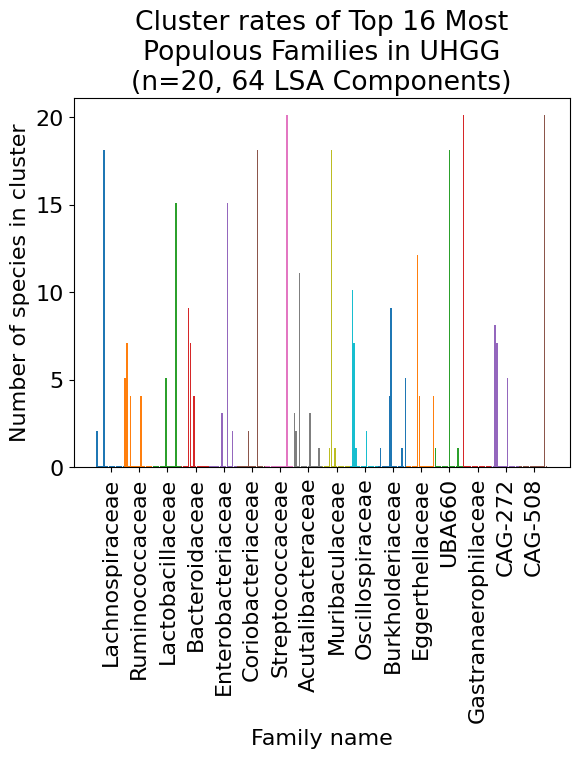

In [69]:
%%time
cluster_num = 16
start_num = 0
plt.rcParams.update({'font.size': 16})

for i in range(0, 16):
#     f = plt.figure(i)
    
#     print(matches[i][start_num:start_num +cluster_num])
    plt.bar(np.arange(cluster_num) + i * (cluster_num), matches[i][start_num:start_num +cluster_num]+.1, .9, label=i)
    
#     plt.bar(np.arange(cluster_num), matches[i][start_num:start_num +cluster_num]+.1, .9, label=i)
#     plt.title("Cluster rates of " + samples['family'].unique()[i] + ', SVD components=2')
#     plt.xticks(np.arange(16))
#     plt.xlabel("Cluster number")
#     plt.yticks(np.arange(20)+1)
#     plt.ylabel("Number of species in cluster")

#     f.show()

plt.title(f"Cluster rates of Top 16 Most\nPopulous Families in UHGG\n(n=20, {n_components} LSA Components)")
plt.xticks(np.arange(cluster_num) *cluster_num + floor(cluster_num/2), samples['family'].unique()[start_num:start_num + cluster_num], rotation=90)
plt.xlabel("Family name")
plt.ylabel("Number of species in cluster")

# plt.title("Cluster identity rates for 20 randomly sampled\nspecies from 16 families\nSVD components=2, df threshold = 50")
#plt.legend(samples['family'].unique(), loc='best')

### Individual clustering plots

CPU times: user 1.1 s, sys: 23.9 ms, total: 1.13 s
Wall time: 1.13 s


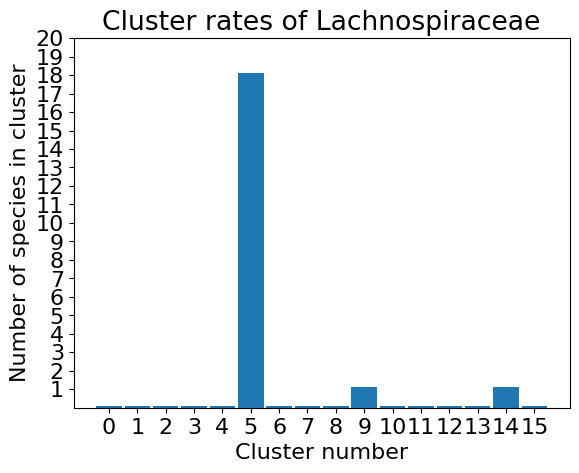

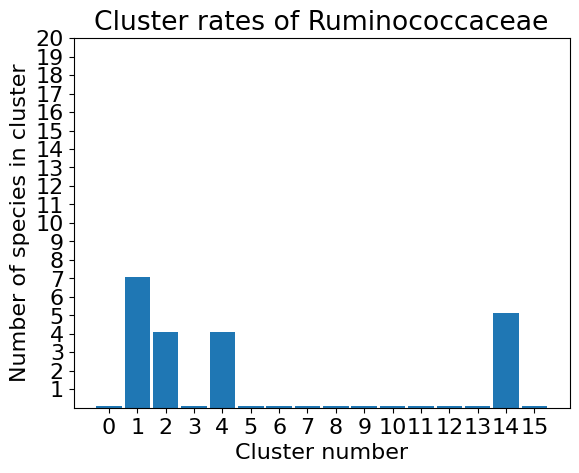

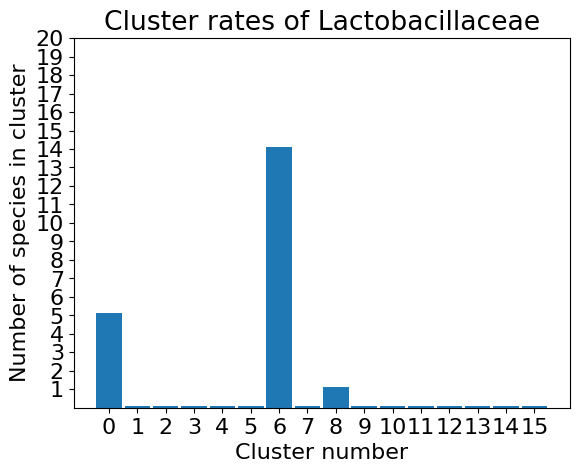

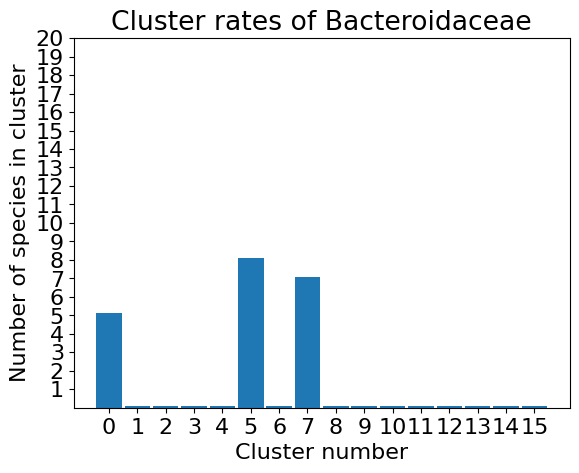

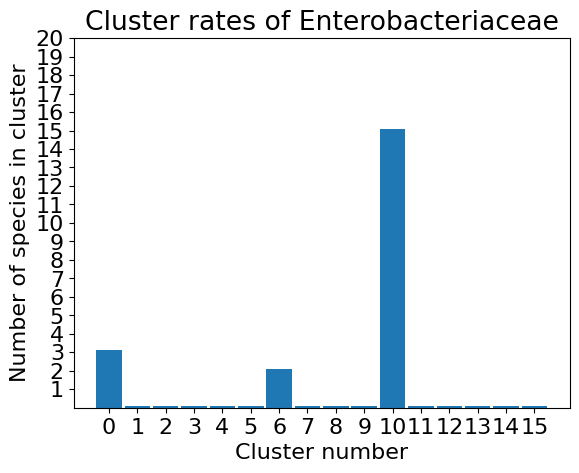

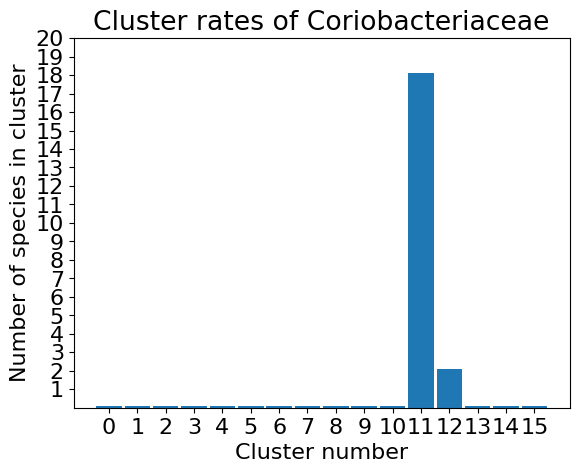

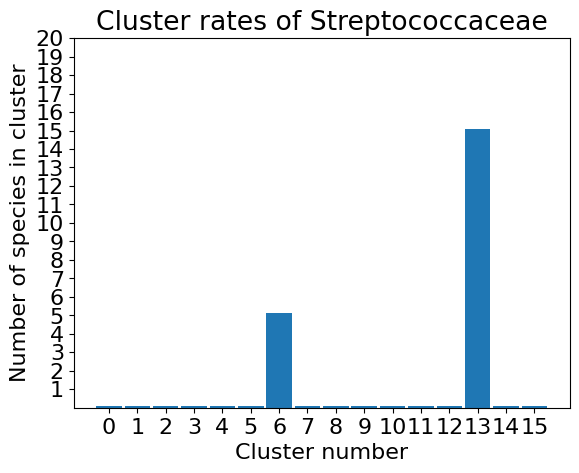

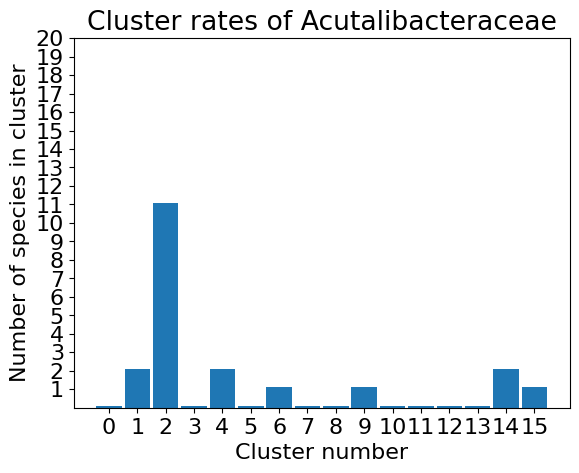

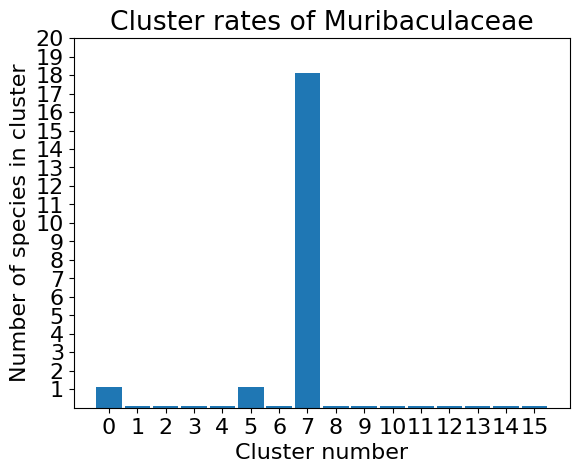

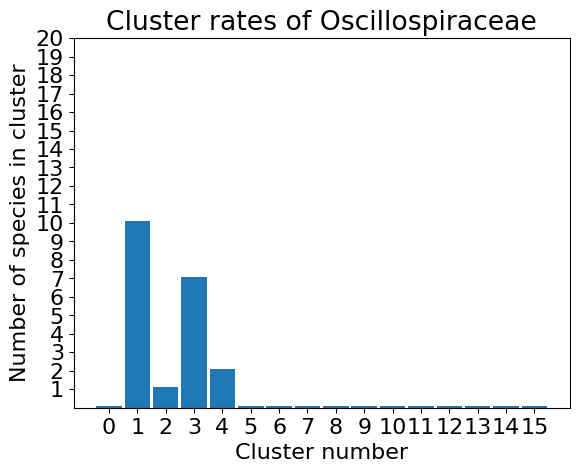

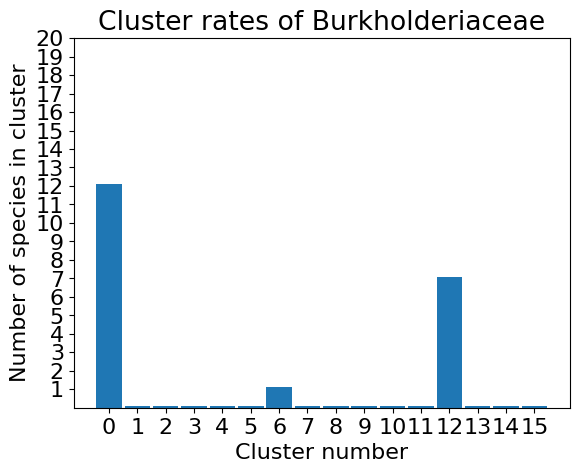

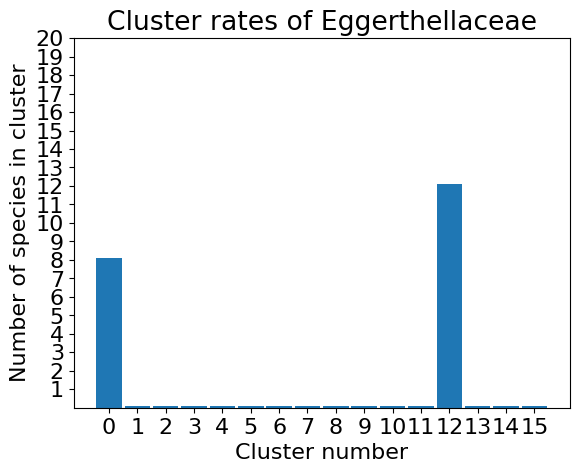

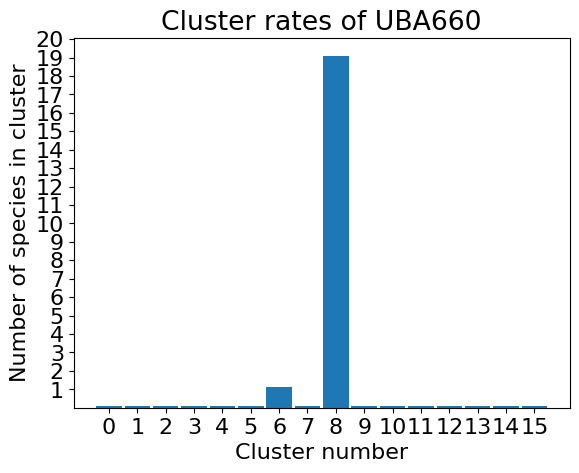

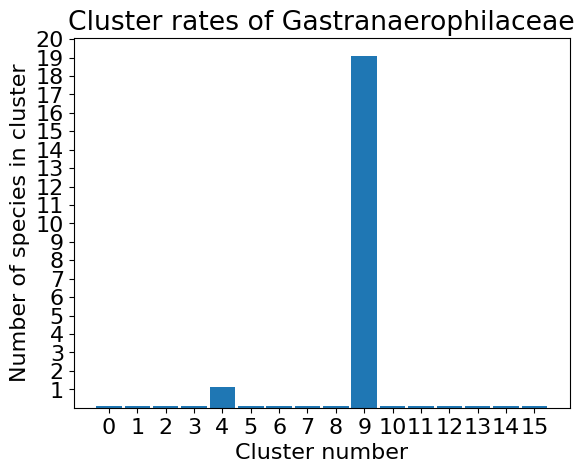

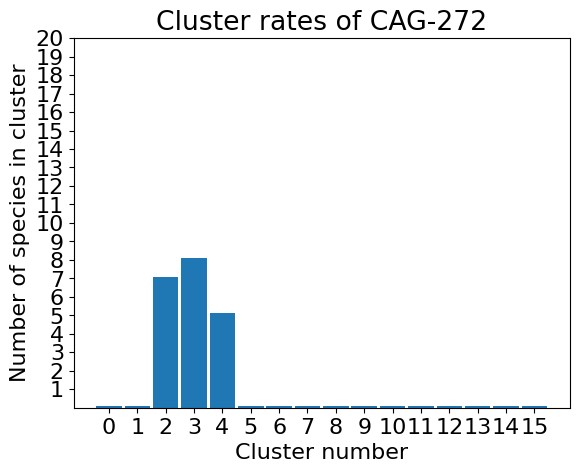

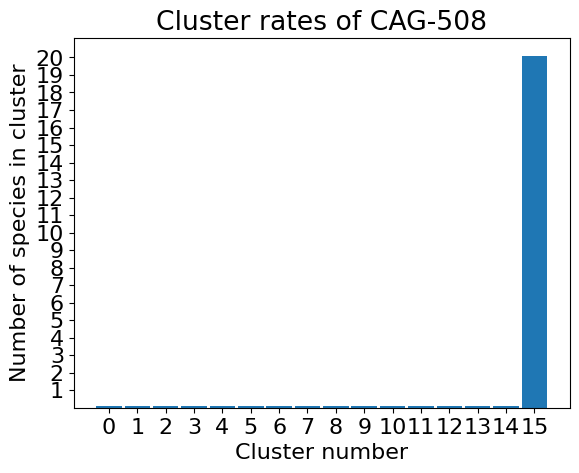

In [64]:
%%time
cluster_num = 16
start_num = 0
file = '/gpfs/scratch/jic286/JohnsonLab/project_figures/lsa_cluster_{}_{}_components.png'
for i in range(0, 16):
    f = plt.figure(i)
    
#     print(matches[i][start_num:start_num +cluster_num])
#     plt.bar(np.arange(cluster_num) + i * (cluster_num), matches[i][start_num:start_num +cluster_num]+.1, .9, label=i)

    plt.bar(np.arange(cluster_num), matches[i][start_num:start_num +cluster_num]+.1, .9, label=i)
    plt.title("Cluster rates of " + samples['family'].unique()[i])# + ', SVD components=2')
    plt.xticks(np.arange(16))
    plt.xlabel("Cluster number")
    plt.yticks(np.arange(20)+1)
    plt.ylabel("Number of species in cluster")
    # plt.savefig(file.format(samples['family'].unique()[i], n_components))

#     f.show()
    

Text(0.5, 1.0, 'Clustered SVD (components=2) of\nTF-IDF (df threshold = 50) of\ntokenized random sample genomes\nfrom families with >50 different species')

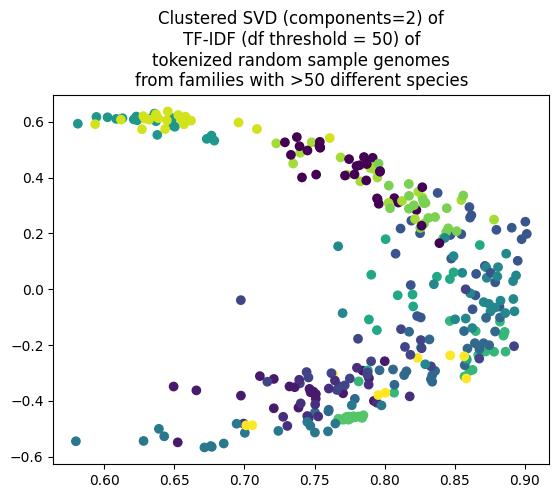

In [77]:

# print(labels)

plt.scatter(data[:,0], data[:,1], c=labels)
plt.title("Clustered SVD (components=2) of\nTF-IDF (df threshold = 50) of\ntokenized random sample genomes\nfrom families with >50 different species")


In [78]:
#checking for label accuracy
families_dict = dict(zip(list(samples['family'].unique()),np.arange(len(samples['family'].unique()))))
hits = 0
for i in range(len(samples['family'])):
    if(labels[i] == families_dict[samples['family'][i]]):
        hits+=1
print("Accuracy: {:.2f}%".format(100 * hits/len(samples['family'])))


Accuracy: 3.44%


In [80]:
#checking labels
for i in range(0, len(labels), 20):
    print(labels[i:i+20])

[0 4 4 0 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
[0 3 3 1 3 9 1 9 9 0 0 0 1 3 0 9 1 1 1 1]
[13 13  7 13 13  7  7 13 13 13 13  7 13 13  7 13 13 13 13 13]
[4 4 4 7 4 5 5 4 7 5 4 4 4 5 5 5 4 7 5 7]
[ 7 10 10 10  7 13 10 13 10  7 10 10 10 10 10 10 10 10 10 10]
[11 11 11 11 11 11 11 11 11 11 11 11 11 11 11  6 11 11  6 11]
[12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12]
[ 3  3  3  1  3  9  0  3  3  3  1  9  3 14  3  0  0  3  3  9]
[4 5 5 7 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
[9 1 1 1 2 1 1 1 2 9 2 2 2 2 1 1 2 3 1 1]
[ 7  7  7 15 15 15  6  7  7  6  7  7  6  6  1 15  7 15  7 13]
[15  6  6  6  7  6  6  6 15  6  7  6 15  6  7  7  6 15  6  6]
[ 0  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8 13]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[9 3 9 3 2 2 3 2 2 2 3 9 2 2 9 3 3 2 9 3]
[14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14]


In [83]:
order_family_dict = {'RF39':'UBA660', 'TANB77':'CAG-508'}
cag_uba = unique_species[unique_species['family'].isin(['CAG-508', 'UBA660'])]
for i in range(len(cag_uba)):
    order = cag_uba['order'][i]
    family = cag_uba['family'][i]
    if(order_family_dict[order]!=family):
        print(cag_uba.iloc[i])


In [84]:
clusts = []
max_species = []
for i in range(cluster_num):
    print(np.argmax(matches[i]), np.max(matches[i]))
    clusts.append(np.argmax(matches[i]))
    max_species.append(int(np.max(matches[i])))
clust_df[f'Top cluster_{n_components}'] = clusts
clust_df[f'Species in top cluster_{n_components}'] = max_species
clust_df.to_csv('/gpfs/scratch/jic286/JohnsonLab/project_figures/uhgg_cluster_data.csv')
clust_df


4 18.0
1 7.0
13 15.0
4 9.0
10 15.0
11 18.0
12 20.0
3 11.0
5 18.0
1 10.0
7 9.0
6 12.0
8 18.0
0 20.0
2 8.0
14 20.0


,Top cluster_2,Species in top cluster_2,Top cluster_4,Species in top cluster_4,Top cluster_8,Species in top cluster_8,Top cluster_16,Species in top cluster_16,Top cluster_32,Species in top cluster_32,Top cluster_64,Species in top cluster_64
Lachnospiraceae,3,6,7,9,8,11,9,11,7,18,4,18
Ruminococcaceae,10,6,3,5,4,7,6,7,1,7,1,7
Lactobacillaceae,5,9,12,10,6,14,8,15,8,14,13,15
Bacteroidaceae,3,6,7,5,3,6,0,11,7,8,4,9
Enterobacteriaceae,1,6,15,9,9,15,11,15,10,15,10,15
Coriobacteriaceae,0,19,4,19,5,18,12,18,11,18,11,18
Streptococcaceae,8,11,6,18,11,16,13,15,13,15,12,20
Acutalibacteraceae,10,4,3,5,10,5,4,5,3,11,3,11
Muribaculaceae,4,6,1,7,3,14,0,16,5,18,5,18
Oscillospiraceae,0,7,8,10,0,7,14,8,1,10,1,10


In [85]:
beep.beep(secs=1)

In [ ]:
basket = [2, 65, 34, 2, 1, 7, 8]
sorted(basket)

In [ ]:
%%time
np.random.seed(42)
# %%timeit
# for name in df.index[[np.random.randint(0,100000) for i in range(5)]]:
#     write_seq_from_gff(name, os.path.join(path, 'genomes'))
# for name in df.index[:5]:
#     with(open(os.path.join(path, 'genomes', name + '.txt'))) as f:
#         for line in f:
#             print(len(line))
# tokenize = partial(tokenize_with_length_threshold, length_threshold = 10)

for i in range(10):
    genome = read_seq_from_txt(df.index[np.random.randint(1000)], os.path.join(path, 'genomes'))
    tokens = bpe.encode(genome, output_type=yttm.OutputType.SUBWORD)
#     tokens = tokenize(genome)
#     genome = retrieve_genome_from_genome_name(df.index[np.random.randint(1000)])
print(tokens[:100])

### Get unique values for class distribution

In [141]:
# print((df['Species_rep'].value_counts().index))
for i in range(10):
#     print(get_clades(df['Species_rep'].value_counts().index[i]+".gff", df)[-1] + " " + str(df['Species_rep'].value_counts()[i]) )
    print(df['Species_rep'].value_counts()[i])
print(df['Species_rep'].value_counts().index[0])
print(df['Species_rep'].value_counts()[:75].sum())

NameError: name 'df' is not defined

In [ ]:
import os
path ='/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/'
gffs = sorted(os.listdir(path + "/gffs"), reverse=True)
# print((gffs[:10]))
seqs = sorted(os.listdir(path + '/genomes'), reverse=True)
print(seqs[:2])
print(178115-177950)

### Assemble filenames

In [70]:
#does not include files with .1
all_files = []
for i in range(1, 4906):
    file = 'MGYG00000' + ("000" + str(i))[-4:] + ".fna"
    if(get_species_status(file, df)):
        all_files.append(file)
print(len(all_files))



3641
CPU times: user 627 ms, sys: 3.99 ms, total: 631 ms
Wall time: 631 ms


In [7]:
all_files = [file + ".fna" for file in df['Species_rep'].unique()] 
print(len(all_files))


4744


In [20]:
### Testing tokenization script
files = os.listdir(os.path.join(path, 'gffs'))
files = [file[:-4] for file in files]
lineages = df['Lineage']
lineages[0]

'd__Bacteria;p__Firmicutes_A;c__Clostridia;o__Peptostreptococcales;f__Peptostreptococcaceae;g__GCA-900066495;s__GCA-900066495 sp902362365'

In [ ]:
def select_df(df, idx, length = 5000):
    idx = idx * length
    if(idx + length>len(df[idx:])):
        return df[idx:]
    else:
        return df[idx:idx + length]
def tokenize_df(df, idx, bpe, path):
    df['Tokenization']=df.index.map(bpe.encode)
    df['Tokenization'].to_csv(os.path.join(path, 'genome_tokenizations_test_{}'.format(idx)))
    

In [258]:
%%time
total_genome_count = 0
species = [file[:-4] for file in all_files]
print(len(df[df.Species_rep.isin(species)]))


289232
CPU times: user 68.7 ms, sys: 988 µs, total: 69.7 ms
Wall time: 68.7 ms


### Select random files


In [6]:
files = [all_files[np.random.randint(len(all_files))]for i in range(10)]
# print(files[0][:-4])
print(files)
names = [get_name_from_file(file, df) for file in files]
names

NameError: name 'all_files' is not defined

### Retrieve Genomes

In [5]:
%%time
all_genomes = [''.join(list(retrieve_genomes(os.path.join('fastas', file)).values())) for file in files]
print(files[0])
print(len(all_genomes[0]))


NameError: name 'files' is not defined

# Inspecting GFFs


In [387]:
import pprint
from BCBio.GFF import GFFExaminer
from BCBio import GFF
from Bio import  SeqRecord
from Bio import Seq
in_file = os.path.join('gffs', os.listdir('gffs')[0])
print()
examiner = GFFExaminer()
in_file = os.path.join('gffs', os.listdir('gffs')[0])
in_handle = open(in_file)
# print(len("".join([str(rec.seq) for rec in GFF.parse(in_handle)])))
for rec in GFF.parse(in_handle):
#     print(rec.seq[:100])
    print(rec)
    break
    
in_handle.close()




ID: MGYG000005934.fa_1
Name: <unknown name>
Description: <unknown description>
Number of features: 86
/gff-version=['3']
/sequence-region=[('MGYG000005934.fa_1', 0, 84762), ('MGYG000005934.fa_2', 0, 76826), ('MGYG000005934.fa_3', 0, 53081), ('MGYG000005934.fa_4', 0, 51457), ('MGYG000005934.fa_5', 0, 51126), ('MGYG000005934.fa_6', 0, 48699), ('MGYG000005934.fa_7', 0, 47102), ('MGYG000005934.fa_8', 0, 41906), ('MGYG000005934.fa_9', 0, 38605), ('MGYG000005934.fa_10', 0, 38014), ('MGYG000005934.fa_11', 0, 37689), ('MGYG000005934.fa_12', 0, 36349), ('MGYG000005934.fa_13', 0, 32483), ('MGYG000005934.fa_14', 0, 32252), ('MGYG000005934.fa_15', 0, 32184), ('MGYG000005934.fa_16', 0, 29789), ('MGYG000005934.fa_17', 0, 29123), ('MGYG000005934.fa_18', 0, 28773), ('MGYG000005934.fa_19', 0, 27342), ('MGYG000005934.fa_20', 0, 26212), ('MGYG000005934.fa_21', 0, 25970), ('MGYG000005934.fa_22', 0, 23504), ('MGYG000005934.fa_23', 0, 22446), ('MGYG000005934.fa_24', 0, 22339), ('MGYG000005934.fa_25', 0, 20

In [247]:
in_file = os.path.join('gffs', os.listdir('gffs')[0])
genome = retrieve_genome_from_gff(in_file)
tokens = tokenize_with_length_threshold(tokens, length_threshold=0)
print(len(tokens))

351149


In [251]:
##Selecting random data
# print(os.listdir('gffs')[0][:-4])


MGYG000003574


In [208]:
genera = set()
families = set()
orders = set()
classes = set()
phyla = set()
domains = set()
print(len(df))
for lineage in df['Lineage'].unique():
    #genuses
    g_start_idx = lineage.find("g__") + len('g__')
    g_end_idx = lineage[g_start_idx:].find(';') + g_start_idx
    genera.add(lineage[g_start_idx:g_end_idx])
    #families
    f_start_idx = lineage.find("f__") + len('f__')
    f_end_idx = lineage[f_start_idx:].find(";") + f_start_idx
    families.add(lineage[f_start_idx:f_end_idx])
    #orders 
    o_start_idx = lineage.find("o__") + len('o__')
    o_end_idx = lineage[o_start_idx:].find(";") + o_start_idx
    orders.add(lineage[o_start_idx:o_end_idx])
    #classes
    c_start_idx = lineage.find("c__") + len('c__')
    c_end_idx = lineage[c_start_idx:].find(";") + c_start_idx
    classes.add(lineage[c_start_idx:c_end_idx])
    #phyla
    p_start_idx = lineage.find("p__") + len('p__')
    p_end_idx = lineage[p_start_idx:].find(";") + p_start_idx
    phyla.add(lineage[p_start_idx:p_end_idx])
    #domains
    d_start_idx = lineage.find("d__") + len('d__')
    d_end_idx = lineage[d_start_idx:].find(";") + d_start_idx
    domains.add(lineage[d_start_idx:d_end_idx])

print("Clade counts:")
print("Domains: "+str(len(domains)))
print("Phyla: "+str(len(phyla)))
print("Classes: " + str(len(classes)))
print("Orders: "+ str(len(orders)))
print("Families: " + str(len(families)))
print("Genera: " + str(len(genera)))
print("Species: " + str(len(df['Lineage'].unique())))
    
    

289232
Clade counts:
Domains: 2
Phyla: 24
Classes: 34
Orders: 92
Families: 214
Genera: 1031
Species: 3910


In [207]:
pd.set_option("display.max_rows", None)
print(df['Country'].value_counts())
pd.set_option("display.max_rows", 10)


China                          57778
United States                  49889
Denmark                        28410
Spain                          21386
Sweden                         19705
Israel                         17617
United Kingdom                 12626
Fiji                           10799
Netherlands                    10213
Austria                         9643
Germany                         8442
Kazakhstan                      5305
Finland                         5286
Mongolia                        5257
France                          4025
Canada                          3996
Russia                          3053
Estonia                         2821
Peru                            1947
Madagascar                      1734
Italy                           1233
United Republic of Tanzania     1177
Japan                            905
Bangladesh                       745
Australia                        615
El Salvador                      477
not provided                     363
B

# Inspecting Dataset for rank/frequency trends

## Tokenizing - Doc2Vec (Toy Example)

### Testing Tokenization Thresholds

In [135]:
%%time
np.random.seed(42)
df = pd.read_csv(os.path.join(path, 'genomes-all_metadata.tsv'), sep='\t', index_col=0)
sample_df = df.iloc[[np.random.randint(0, 1000) for i in range(10)]]
thresholds = [0]#, 10, 20, 30, 40, 50]
for threshold in thresholds:
#     tokenize = partial(tokenize_with_length_threshold, length_threshold = threshold)
    print("Threshold:",threshold)
    for i, name in enumerate(sample_df.index):
        genome = read_seq_from_txt(name, os.path.join(path, 'genomes'))
#         tokens = tokenize(genome)
        tokens = bpe.encode(genome, output_type=yttm.OutputType.SUBWORD)
        print(name, get_name_from_file(name + '.gff', sample_df) + ":", len(tokens))

Threshold: 0
MGYG000000103 B. massiliensis: 520421
MGYG000000437 A. sp001941065: 385599
MGYG000000865 C. sp900554255: 180954
MGYG000000271 R. sp900552665: 422398
MGYG000000107 K. oxytoca: 685553
MGYG000000072 U. sp900066845: 304159
MGYG000000705 C. sp000434435: 192859
MGYG000000021 L. vaginalis_A: 230675
MGYG000000617 RUG410 [none]: 181707
MGYG000000122 S. epidermidis: 297303
CPU times: user 30.2 s, sys: 151 ms, total: 30.3 s
Wall time: 33.1 s


In [85]:
%%time
np.random.seed(42)
def read_corpus(df, tokens_only=False, length_threshold=0):
    for i, name in enumerate(df['Genome']):
        genome = retrieve_genome_from_gff(os.path.join(path, 'gffs', name + '.gff'))
        tokens = tokenize(length_threshold=length_threshold)
        if(tokens_only):
            yield tokens
        else:
            # For training data, add tags
            yield (gensim.models.doc2vec.TaggedDocument(tokens, [i]), dtype='object')
sample_df = df.iloc[[np.random.randint(0, 100000) for i in range(500)]]
train, test = train_test_split(sample_df, test_size=.1)

train_corpus = read_corpus(train)
print("listizing train_corpus")

train_corpus = list(train_corpus)
test_corpus = (read_corpus(test, tokens_only=True))
print('listizing test_corpus')
test_corpus = list(test_corpus)


SyntaxError: invalid syntax (<unknown>, line 5)

In [84]:
%%time
model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40)
model.build_vocab(train_corpus)


AttributeError: 'numpy.ndarray' object has no attribute 'words'

In [367]:
# Inspecting Dataset for rank/frequency trends

## Tokenizing

In [367]:
# Inspecting Dataset for rank/frequency trends

## Tokenizing

In [60]:
%%time
model.train(list(train_corpus), total_examples=model.corpus_count, epochs=model.epochs)

CPU times: user 24.2 ms, sys: 14 ms, total: 38.2 ms
Wall time: 29.5 ms


In [64]:
ranks = []
second_ranks = []
train_corpus = list(train_corpus)
print(len(list(train_corpus)))
for doc_id in range(len(train_corpus)):
    inferred_vector = model.infer_vector(train_corpus[doc_id].words)
    sims = model.dv.most_similar([inferred_vector], topn=len(model.dv))
    rank = [docid for docid, sim in sims].index(doc_id)
    ranks.append(rank)

    second_ranks.append(sims[1])

0


In [63]:
import collections

counter = collections.Counter(ranks)
print(counter)


Counter()


In [128]:
%%time
from ast import literal_eval
import pickle
from math import floor
### Testing section rewrite
test_df = df[:50]   
path ='/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/'
for name in test_df.index:
    seq = retrieve_genome_from_genome_name(name)
    tokenization = np.array(bpe.encode(seq))
    np.save(os.path.join(path, 'tokenizations', name + '.npy'), tokenization)
    
# test_df['Seq'] = test_df.index.map(retrieve_genome_from_genome_name)
# test_df['Tokenization']=test_df['Seq'].apply(lambda s: np.array(bpe.encode(s)))
# print(type(test_df['Tokenization'][0]))

# denom = 5
# path ='/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/tokenizations/genome_tokenizations_test_'
# idx = 7
# name = df.index[idx]
# file_idx = str(floor(idx/denom))
# test_df =pd.read_csv(path + file_idx+ '.tsv', index_col = 0, delimiter = '\t')
# tokenization = test_df.loc[name]['Tokenization']
# tokenization = literal_eval(tokenization)



TypeError: unsupported operand type(s) for +: 'int' and 'str'

In [383]:
%%time
tokenization = np.load(os.path.join(path, 'tokenizations', name + '.npy'))
tokenization[:10]


CPU times: user 2.34 ms, sys: 1.07 ms, total: 3.4 ms
Wall time: 2.6 ms


array([ 122342,  272700, 1684803,  517466,    5546,  904658,     232,
         37454,     101,   46030])

### Messing around with multiprocessing

In [355]:
%%time
from multiprocessing import Process


def print_func(continent='Asia'):
    pass
    print('The name of continent is : ', continent)

if __name__ == "__main__":  # confirms that the code is under main function
    names = ['America', 'Europe', 'Africa']
    procs = []
    proc = Process(target=print_func)  # instantiating without any argument
    procs.append(proc)
    proc.start()

    # instantiating process with arguments
    for name in names:
        # print(name)
        proc = Process(target=print_func, args=(name,))
        procs.append(proc)
        proc.start()

    # complete the processes
    for proc in procs:
        proc.join()


The name of continent is :  The name of continent is : Asia
 The name of continent is : America 
Europe
The name of continent is :  Africa
CPU times: user 11.6 ms, sys: 190 ms, total: 202 ms
Wall time: 306 ms


In [358]:
from multiprocessing import Queue

colors = ['red', 'green', 'blue', 'black']
cnt = 1
# instantiating a queue object
queue = Queue()
print('pushing items to queue:')
for color in colors:
    print('item no: ', cnt, ' ', color)
    queue.put(color)
    cnt += 1

print('\npopping items from queue:')
cnt = 1
while not queue.empty():
    print('item no: ', cnt, ' ', queue.get())
    cnt += 1


pushing items to queue:
item no:  1   red
item no:  2   green
item no:  3   blue
item no:  4   black

popping items from queue:
item no:  1   red
item no:  2   green
item no:  3   blue
item no:  4   black


In [360]:

from multiprocessing import Pool

import time

work = (["A", 5], ["B", 2], ["C", 1], ["D", 3])


def work_log(work_data):
    print(" Process %s waiting %s seconds" % (work_data[0], work_data[1]))
    time.sleep(int(work_data[1]))
    print(" Process %s Finished." % work_data[0])


def pool_handler():
    p = Pool(2)
    p.map(work_log, work)


if __name__ == '__main__':
    pool_handler()


 Process A waiting 5 seconds Process B waiting 2 seconds

 Process B Finished.
 Process C waiting 1 seconds
 Process C Finished.
 Process D waiting 3 seconds
 Process A Finished.
 Process D Finished.


In [377]:
%%time
from multiprocessing import Pool
test_df = df[:50]
def tokenize_from_name(name):
    seq = retrieve_genome_from_genome_name(name)
    tokens = np.array(bpe.encode(seq))
    np.save(os.path.join('/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/tokenizations', name), tokens)
def pool_handler():
    p = Pool(40)
    p.map(tokenize_from_name, test_df.index)
pool_handler()


CPU times: user 175 ms, sys: 2.28 s, total: 2.46 s
Wall time: 43.8 s


In [107]:
print(len(os.listdir('/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/gffs')))

286419


# FTP/download test

In [67]:
ftp = ftplib.FTP("ftp.ebi.ac.uk")
ftp.login("anonymous", "foo")
filepath = 'pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/'
ftp.cwd(filepath)
print(ftp.pwd())
def getFile(ftp, filename):
    ftp.retrbinary("RETR " + filename,open(os.path.join(filepath, filename), 'wb').write )

# getFile(ftp,"MGYG0000001/MGYG000000112/genomes1/MGYG000000112.gff.gz")
ftp.quit()

for line in data[:10]:
    print("-", line)
print(len(data))

/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes
- drwxr-xr-x  101 ftp      ftp          3069 Dec 07  2021 MGYG0000000
- drwxr-xr-x  102 ftp      ftp          3100 Dec 07  2021 MGYG0000001
- drwxr-xr-x  102 ftp      ftp          3100 Dec 07  2021 MGYG0000002
- drwxr-xr-x   98 ftp      ftp          2976 Dec 07  2021 MGYG0000003
- drwxr-xr-x  101 ftp      ftp          3069 Dec 07  2021 MGYG0000004
- drwxr-xr-x  101 ftp      ftp          3069 Dec 07  2021 MGYG0000005
- drwxr-xr-x  100 ftp      ftp          3038 Dec 07  2021 MGYG0000006
- drwxr-xr-x  101 ftp      ftp          3071 Dec 07  2021 MGYG0000007
- drwxr-xr-x   86 ftp      ftp          2604 Dec 07  2021 MGYG0000008
- drwxr-xr-x   96 ftp      ftp          2914 Dec 07  2021 MGYG0000009
50


In [124]:
ftp = ftplib.FTP("ftp.ebi.ac.uk")
ftp.login("anonymous", "foo")
filepath = 'pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/'
import sys
import ftplib
import os
from ftplib import FTP
ftp = ftplib.FTP("ftp.ebi.ac.uk")
ftp.login("anonymous", "foo")
filepath = '/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/'
ftp.cwd(filepath)
os.chdir(path)
def downloadFiles(path,destination):
    print(ftp.pwd())

#path & destination are str of the form "/dir/folder/something/"
#path should be the abs path to the root FOLDER of the file tree to download
    try:

        ftp.cwd(path)
#         #clone path to destination
        os.chdir(destination)
        os.mkdir(destination[0:len(destination)-1]+path)
        print (destination[0:len(destination)-1]+path+" built")
    except OSError:
#         #folder already exists at destination
        pass
    except ftplib.error_perm:
#         #invalid entry (ensure input form: "/dir/folder/something/")
        print ("error: could not change to "+path)
        sys.exit("ending session")

    #list children:
    filelist=ftp.nlst()
    
    for file in filelist:
        try:
            #this will check if file is folder:
            ftp.cwd(path+file+"/")
            #if so, explore it:
            downloadFiles(path+file+"/",destination)
        except ftplib.error_perm:
            #not a folder with accessible content
            #download & return
            os.chdir(destination[0:len(destination)-1]+path)
            #possibly need a permission exception catch:
            with open(os.path.join(destination,file),"wb") as f:
                ftp.retrbinary("RETR "+file, f.write)
            print (file + " downloaded")
    return


source="/MGYG0000001/MGYG000000112/genomes1/"
dest = os.getcwd()+ '/'
downloadFiles( source, dest)


/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes


error_perm: 550 Failed to change directory.

In [130]:
###This is the one that works
from contextlib import closing
from urllib.request import urlopen

url = 'ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000031/MGYG000003137/genomes1/MGYG000223221.gff.gz'
target_path = 'fastas/MGYG000223221.gff.gz'

with closing(urlopen(url)) as source:
    with open(target_path, 'wb') as target:
        target.write(source.read())

In [187]:
###This is the one that works
from contextlib import closing
from urllib.request import urlopen
import pandas as pd
import os
path ='/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/'
os.chdir(path)
df = pd.read_csv(os.path.join(path, 'genomes-all_metadata.tsv'), sep='\t', index_col=0)
for i in range(len(df['FTP_download'])+1):
    
    url = df['FTP_download'][i]
    target_path = url[url.rfind('/')+1:-3]
    with closing(urlopen(url)) as source:
        with gzip.open(source) as f:
            with open(os.path.join('gffs',target_path), 'wb') as target:
                target.write((f.read()))
#                 for line in f.readlines():
#                     target.write(line)
    break
with(open(os.path.join('gffs',target_path), 'rb')) as target:
    print(str(target.readlines()[0][:100], encoding='utf-8'))

##gff-version 3



In [9]:
path ='/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/'
gff_files = os.listdir(os.path.join(path, 'gffs'))
for i in range(len(df['FTP_download'])+1):
    url = df['FTP_download'][i]
    target_path = url[url.rfind('/')+1:-3]
    if(target_path not in gff_files):
        print(target_path)

MGYG000094631.gff
MGYG000094632.gff
MGYG000094633.gff
MGYG000094634.gff
MGYG000094635.gff
MGYG000094636.gff
MGYG000094637.gff
MGYG000094638.gff
MGYG000094639.gff
MGYG000094729.gff
MGYG000094730.gff
MGYG000094731.gff
MGYG000094732.gff
MGYG000094733.gff
MGYG000094734.gff
MGYG000094735.gff
MGYG000094736.gff
MGYG000094737.gff
MGYG000094738.gff
MGYG000094739.gff
MGYG000094740.gff
MGYG000094741.gff
MGYG000094742.gff
MGYG000094743.gff
MGYG000094744.gff
MGYG000094745.gff
MGYG000094746.gff
MGYG000094747.gff
MGYG000094748.gff
MGYG000094749.gff
MGYG000094750.gff
MGYG000094751.gff
MGYG000094752.gff
MGYG000094753.gff
MGYG000094754.gff
MGYG000094755.gff
MGYG000094756.gff
MGYG000094757.gff
MGYG000094758.gff
MGYG000094759.gff
MGYG000094760.gff
MGYG000094761.gff
MGYG000094762.gff
MGYG000094763.gff
MGYG000094764.gff
MGYG000094765.gff
MGYG000094766.gff
MGYG000094767.gff
MGYG000094768.gff
MGYG000094769.gff
MGYG000094770.gff
MGYG000094771.gff
MGYG000094772.gff
MGYG000094773.gff
MGYG000094774.gff
MGYG000094

KeyboardInterrupt: 

MGYG000095677.gff
MGYG000095678.gff
MGYG000095679.gff
MGYG000095680.gff
MGYG000095681.gff
MGYG000095682.gff
MGYG000095683.gff
MGYG000095684.gff
MGYG000095685.gff
MGYG000095686.gff
MGYG000095687.gff
MGYG000095688.gff
MGYG000095689.gff
MGYG000095690.gff
MGYG000095691.gff
MGYG000095692.gff
MGYG000095693.gff
MGYG000095694.gff
MGYG000095695.gff
MGYG000095696.gff
MGYG000095697.gff
MGYG000095698.gff
MGYG000095699.gff
MGYG000095700.gff
MGYG000095701.gff
MGYG000095702.gff
MGYG000095703.gff
MGYG000095704.gff
MGYG000095705.gff
MGYG000095706.gff
MGYG000095707.gff
MGYG000095708.gff
MGYG000095709.gff
MGYG000095710.gff
MGYG000095711.gff
MGYG000095712.gff
MGYG000095713.gff
MGYG000095714.gff
MGYG000095715.gff
MGYG000095716.gff
MGYG000095717.gff
MGYG000095718.gff
MGYG000095719.gff
MGYG000095720.gff
MGYG000095721.gff
MGYG000095722.gff
MGYG000095723.gff
MGYG000095724.gff
MGYG000095725.gff
MGYG000095726.gff
MGYG000095727.gff
MGYG000095728.gff
MGYG000095729.gff
MGYG000095730.gff
MGYG000095731.gff
MGYG000095

MGYG000096260.gff
MGYG000096261.gff
MGYG000096262.gff
MGYG000096263.gff
MGYG000096264.gff
MGYG000096265.gff
MGYG000096266.gff
MGYG000096267.gff
MGYG000096268.gff
MGYG000096269.gff
MGYG000096270.gff
MGYG000096271.gff
MGYG000096272.gff
MGYG000096273.gff
MGYG000096274.gff
MGYG000096275.gff
MGYG000096276.gff
MGYG000096277.gff
MGYG000096278.gff
MGYG000096279.gff
MGYG000096280.gff
MGYG000096281.gff
MGYG000096282.gff
MGYG000096283.gff
MGYG000096284.gff
MGYG000096285.gff
MGYG000096286.gff
MGYG000096287.gff
MGYG000096288.gff
MGYG000096289.gff
MGYG000096290.gff
MGYG000096291.gff
MGYG000096292.gff
MGYG000096293.gff
MGYG000096294.gff
MGYG000096295.gff
MGYG000096296.gff
MGYG000096297.gff
MGYG000096298.gff
MGYG000096299.gff
MGYG000096300.gff
MGYG000096301.gff
MGYG000096302.gff
MGYG000096303.gff
MGYG000096304.gff
MGYG000096305.gff
MGYG000096306.gff
MGYG000096307.gff
MGYG000096308.gff
MGYG000096309.gff
MGYG000096310.gff
MGYG000096311.gff
MGYG000096312.gff
MGYG000096313.gff
MGYG000096314.gff
MGYG000096

MGYG000096722.gff
MGYG000096723.gff
MGYG000096724.gff
MGYG000096725.gff
MGYG000096726.gff
MGYG000096727.gff
MGYG000096728.gff
MGYG000096729.gff
MGYG000096730.gff
MGYG000096731.gff
MGYG000096732.gff
MGYG000096733.gff
MGYG000096734.gff
MGYG000096735.gff
MGYG000096736.gff
MGYG000096737.gff
MGYG000096738.gff
MGYG000096739.gff
MGYG000096740.gff
MGYG000096741.gff
MGYG000096742.gff
MGYG000096743.gff
MGYG000096744.gff
MGYG000096745.gff
MGYG000096746.gff
MGYG000096747.gff
MGYG000096748.gff
MGYG000096749.gff
MGYG000096750.gff
MGYG000096751.gff
MGYG000096752.gff
MGYG000096753.gff
MGYG000096754.gff
MGYG000096755.gff
MGYG000096756.gff
MGYG000096757.gff
MGYG000096758.gff
MGYG000096759.gff
MGYG000096760.gff
MGYG000096761.gff
MGYG000096762.gff
MGYG000096763.gff
MGYG000096764.gff
MGYG000096765.gff
MGYG000096766.gff
MGYG000096767.gff
MGYG000096768.gff
MGYG000096769.gff
MGYG000096770.gff
MGYG000096771.gff
MGYG000096772.gff
MGYG000096773.gff
MGYG000096774.gff
MGYG000096775.gff
MGYG000096776.gff
MGYG000096

MGYG000097353.gff
MGYG000097354.gff
MGYG000097355.gff
MGYG000097356.gff
MGYG000097357.gff
MGYG000097358.gff
MGYG000097359.gff
MGYG000097360.gff
MGYG000097361.gff
MGYG000097362.gff
MGYG000097363.gff
MGYG000097364.gff
MGYG000097365.gff
MGYG000097366.gff
MGYG000097367.gff
MGYG000097368.gff
MGYG000097369.gff
MGYG000097370.gff
MGYG000097371.gff
MGYG000097372.gff
MGYG000097373.gff
MGYG000097374.gff
MGYG000097375.gff
MGYG000097376.gff
MGYG000097377.gff
MGYG000097378.gff
MGYG000097379.gff
MGYG000097380.gff
MGYG000097381.gff
MGYG000097382.gff
MGYG000097383.gff
MGYG000097384.gff
MGYG000097385.gff
MGYG000097386.gff
MGYG000097387.gff
MGYG000097388.gff
MGYG000097389.gff
MGYG000097390.gff
MGYG000097391.gff
MGYG000097392.gff
MGYG000097393.gff
MGYG000097394.gff
MGYG000097395.gff
MGYG000097396.gff
MGYG000097397.gff
MGYG000097398.gff
MGYG000097399.gff
MGYG000097400.gff
MGYG000097401.gff
MGYG000097402.gff
MGYG000097403.gff
MGYG000097404.gff
MGYG000097405.gff
MGYG000097406.gff
MGYG000097407.gff
MGYG000097

MGYG000097844.gff
MGYG000097845.gff
MGYG000097846.gff
MGYG000097847.gff
MGYG000097848.gff
MGYG000097849.gff
MGYG000097850.gff
MGYG000097851.gff
MGYG000097852.gff
MGYG000097853.gff
MGYG000097854.gff
MGYG000097855.gff
MGYG000097856.gff
MGYG000097857.gff
MGYG000097858.gff
MGYG000097859.gff
MGYG000097860.gff
MGYG000097861.gff
MGYG000097862.gff
MGYG000097863.gff
MGYG000097864.gff
MGYG000097865.gff
MGYG000097866.gff
MGYG000097867.gff
MGYG000097868.gff
MGYG000097869.gff
MGYG000097870.gff
MGYG000097871.gff
MGYG000097872.gff
MGYG000097873.gff
MGYG000097874.gff
MGYG000097875.gff
MGYG000097876.gff
MGYG000097877.gff
MGYG000097878.gff
MGYG000097879.gff
MGYG000097880.gff
MGYG000097881.gff
MGYG000097882.gff
MGYG000097883.gff
MGYG000097884.gff
MGYG000097885.gff
MGYG000097886.gff
MGYG000097887.gff
MGYG000097888.gff
MGYG000097889.gff
MGYG000097890.gff
MGYG000097891.gff
MGYG000097892.gff
MGYG000097893.gff
MGYG000097894.gff
MGYG000097895.gff
MGYG000097896.gff
MGYG000097897.gff
MGYG000097898.gff
MGYG000097

MGYG000098465.gff
MGYG000098466.gff
MGYG000098467.gff
MGYG000098468.gff
MGYG000098469.gff
MGYG000098470.gff
MGYG000098471.gff
MGYG000098472.gff
MGYG000098473.gff
MGYG000098474.gff
MGYG000098475.gff
MGYG000098476.gff
MGYG000098477.gff
MGYG000098478.gff
MGYG000098479.gff
MGYG000098480.gff
MGYG000098481.gff
MGYG000098482.gff
MGYG000098483.gff
MGYG000098484.gff
MGYG000098485.gff
MGYG000098486.gff
MGYG000098487.gff
MGYG000098488.gff
MGYG000098489.gff
MGYG000098490.gff
MGYG000098491.gff
MGYG000098492.gff
MGYG000098493.gff
MGYG000098494.gff
MGYG000098495.gff
MGYG000098496.gff
MGYG000098497.gff
MGYG000098498.gff
MGYG000098499.gff
MGYG000098500.gff
MGYG000098501.gff
MGYG000098502.gff
MGYG000098503.gff
MGYG000098504.gff
MGYG000098505.gff
MGYG000098506.gff
MGYG000098507.gff
MGYG000098508.gff
MGYG000098509.gff
MGYG000098510.gff
MGYG000098511.gff
MGYG000098512.gff
MGYG000098513.gff
MGYG000098514.gff
MGYG000098515.gff
MGYG000098516.gff
MGYG000098517.gff
MGYG000098518.gff
MGYG000098519.gff
MGYG000098

MGYG000098926.gff
MGYG000098927.gff
MGYG000098928.gff
MGYG000098929.gff
MGYG000098930.gff
MGYG000098931.gff
MGYG000098932.gff
MGYG000098933.gff
MGYG000098934.gff
MGYG000098935.gff
MGYG000098936.gff
MGYG000098937.gff
MGYG000098938.gff
MGYG000098939.gff
MGYG000098940.gff
MGYG000098941.gff
MGYG000098942.gff
MGYG000098943.gff
MGYG000098944.gff
MGYG000098945.gff
MGYG000098946.gff
MGYG000098947.gff
MGYG000098948.gff
MGYG000098949.gff
MGYG000098950.gff
MGYG000098951.gff
MGYG000098952.gff
MGYG000098953.gff
MGYG000098954.gff
MGYG000098955.gff
MGYG000098956.gff
MGYG000098957.gff
MGYG000098958.gff
MGYG000098959.gff
MGYG000098960.gff
MGYG000098961.gff
MGYG000098962.gff
MGYG000098963.gff
MGYG000098964.gff
MGYG000098965.gff
MGYG000098966.gff
MGYG000098967.gff
MGYG000098968.gff
MGYG000098969.gff
MGYG000098970.gff
MGYG000098971.gff
MGYG000098972.gff
MGYG000098973.gff
MGYG000098974.gff
MGYG000098975.gff
MGYG000098976.gff
MGYG000098977.gff
MGYG000098978.gff
MGYG000098979.gff
MGYG000098980.gff
MGYG000098

KeyboardInterrupt: 

In [17]:
path ='/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/'
gff_files = sorted(os.listdir(os.path.join(path, 'gffs')))
for i in range(1, len(gff_files)+1):
    file_num = gff_files[i]
    file_num = int(file_num[4:file_num.rfind('.')])
    if file_num !=i+1 and file_num !=341:
        print(gff_files[i])
        print(file_num)
        print(i)
        break

MGYG000000342.gff
342
340


In [19]:
###This is the one that works
from contextlib import closing
from urllib.request import urlopen
import gzip
import pandas as pd
import os
from multiprocessing import cpu_count, Pool
path ='/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/'
os.chdir(path)
df = pd.read_csv(os.path.join(path, 'genomes-all_metadata.tsv'), sep='\t')
for i in range(94460, 289233):

    url = df['FTP_download'][i]
    target_path = url[url.rfind('/')+1:-3]
    connected= False
    while not connected:
        try:
            with closing(urlopen(url)) as source:
                with gzip.open(source) as f:
                    with open(os.path.join('gffs',target_path), 'wb') as target:
                        target.write((f.read()))
                        connected=True
        except:
            connected=False
# print("All content downloaded")
#def download_gff(url):
#    target_path = url[url.rfind('/')+1:-3]
#    connected= False
#    while not connected:
#        try:
#            with closing(urlopen(url)) as source:
#                with gzip.open(source) as f:
#                    with open(os.path.join('gffs',target_path), 'wb') as target:
#                        target.write((f.read()))
#                        connected=True
#         except:
#             connected=False
#def pool_handler(df):
#    p = Pool(40)
#    p.map(download_gff, df['FTP_download'][94478:])

#if __name__=="__main__":
#    path ='/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/'
#    os.chdir(path)
#    df = pd.read_csv(os.path.join(path, 'genomes-all_metadata.tsv'), sep='\t')
#    pool_handler(df)
#    print("All content downloaded")




SyntaxError: default 'except:' must be last (2156025061.py, line 22)

In [54]:
###TEST
from contextlib import closing
from urllib.request import urlopen
import gzip
import pandas as pd
import os
from multiprocessing import cpu_count, Pool
path ='/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/'
os.chdir(path)
df = pd.read_csv(os.path.join(path, 'genomes-all_metadata.tsv'), sep='\t', index_col=0)
df.loc[missing[0]]['FTP_download']

'ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000025/MGYG000002545/genomes2/MGYG000178116.gff.gz'

In [5]:
%%time
###This is the one that works
from contextlib import closing
from urllib.request import urlopen
import gzip
import pandas as pd
import os
from multiprocessing import cpu_count, Pool
path ='/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/'
os.chdir(path)
df = pd.read_csv(os.path.join(path, 'genomes-all_metadata.tsv'), sep='\t', index_col=0)
for i in range(len(missing)):

    url = df.loc[missing[i]]['FTP_download']
    print(url)
    target_path = url[url.rfind('/')+1:-3]
    connected= False
    while not connected:
        try:
            with closing(urlopen(url)) as source:
                with gzip.open(source) as f:
                    with open(os.path.join('gffs',target_path), 'wb') as target:
                        target.write((f.read()))
                        connected=True
        except:
            connected=False
print("All content downloaded")
#def download_gff(url):
#    target_path = url[url.rfind('/')+1:-3]
#    connected= False
#    while not connected:
#        try:
#            with closing(urlopen(url)) as source:
#                with gzip.open(source) as f:
#                    with open(os.path.join('gffs',target_path), 'wb') as target:
#                        target.write((f.read()))
#                        connected=True
#def pool_handler(df):
#    p = Pool(40)
#    p.map(download_gff, df['FTP_download'][94478:])

#if __name__=="__main__":
#    path ='/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/'
#    os.chdir(path)
#    df = pd.read_csv(os.path.join(path, 'genomes-all_metadata.tsv'), sep='\t')
#    pool_handler(df)
#    print("All content downloaded")




ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000009/MGYG000000979/genomes1/MGYG000243109.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000000/MGYG000000022/genomes2/MGYG000243110.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000013/MGYG000001359/genomes1/MGYG000243111.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000002/MGYG000000236/genomes1/MGYG000243112.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000029/MGYG000002993/genomes1/MGYG000243113.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000041/MGYG000004196/genomes1/MGYG000243114.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000000/MGYG000000003/genomes1/MGYG00

ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000024/MGYG000002478/genomes5/MGYG000243166.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000005/MGYG000000507/genomes1/MGYG000243167.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000007/MGYG000000725/genomes1/MGYG000243168.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000013/MGYG000001380/genomes2/MGYG000243169.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000046/MGYG000004612/genomes1/MGYG000243170.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000020/MGYG000002060/genomes1/MGYG000243171.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000036/MGYG000003681/genomes2/MGYG00

ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000001/MGYG000000190/genomes2/MGYG000243223.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000006/MGYG000000644/genomes1/MGYG000243224.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000002/MGYG000000251/genomes3/MGYG000243225.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000024/MGYG000002478/genomes5/MGYG000243226.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000040/MGYG000004059/genomes1/MGYG000243227.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000025/MGYG000002538/genomes1/MGYG000243228.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000024/MGYG000002470/genomes1/MGYG00

ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000002/MGYG000000254/genomes2/MGYG000247071.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000005/MGYG000000562/genomes1/MGYG000247072.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000024/MGYG000002478/genomes5/MGYG000247073.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000001/MGYG000000122/genomes1/MGYG000247074.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000000/MGYG000000018/genomes1/MGYG000247075.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000013/MGYG000001313/genomes1/MGYG000247076.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000004/MGYG000000431/genomes1/MGYG00

ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000002/MGYG000000258/genomes4/MGYG000247128.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000000/MGYG000000084/genomes2/MGYG000247129.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000001/MGYG000000144/genomes3/MGYG000247130.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000013/MGYG000001338/genomes2/MGYG000247131.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000013/MGYG000001337/genomes1/MGYG000247132.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000023/MGYG000002396/genomes1/MGYG000247133.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000000/MGYG000000084/genomes2/MGYG00

ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000000/MGYG000000084/genomes2/MGYG000247185.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000024/MGYG000002478/genomes5/MGYG000247186.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000001/MGYG000000193/genomes1/MGYG000247187.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000024/MGYG000002478/genomes5/MGYG000247188.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000038/MGYG000003899/genomes1/MGYG000247189.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000025/MGYG000002530/genomes2/MGYG000247190.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000043/MGYG000004337/genomes1/MGYG00

ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000017/MGYG000001737/genomes1/MGYG000247242.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000024/MGYG000002445/genomes1/MGYG000247243.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000024/MGYG000002478/genomes5/MGYG000247244.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000023/MGYG000002321/genomes3/MGYG000247245.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000000/MGYG000000041/genomes2/MGYG000247246.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000023/MGYG000002395/genomes3/MGYG000247247.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000036/MGYG000003686/genomes2/MGYG00

ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000000/MGYG000000078/genomes2/MGYG000247299.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000000/MGYG000000044/genomes2/MGYG000247300.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000023/MGYG000002366/genomes1/MGYG000247301.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000045/MGYG000004508/genomes1/MGYG000247302.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000015/MGYG000001564/genomes1/MGYG000247303.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000024/MGYG000002492/genomes7/MGYG000247304.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000010/MGYG000001029/genomes2/MGYG00

ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000002/MGYG000000251/genomes3/MGYG000247356.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000010/MGYG000001029/genomes2/MGYG000247357.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000036/MGYG000003694/genomes3/MGYG000247358.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000024/MGYG000002492/genomes7/MGYG000247359.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000029/MGYG000002926/genomes1/MGYG000247360.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000025/MGYG000002570/genomes2/MGYG000247361.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000017/MGYG000001756/genomes1/MGYG00

ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000029/MGYG000002994/genomes1/MGYG000247413.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000039/MGYG000003949/genomes1/MGYG000247414.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000002/MGYG000000251/genomes3/MGYG000247415.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000025/MGYG000002538/genomes1/MGYG000247416.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000036/MGYG000003681/genomes2/MGYG000247417.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000002/MGYG000000217/genomes2/MGYG000247418.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000002/MGYG000000243/genomes1/MGYG00

ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000027/MGYG000002773/genomes1/MGYG000247470.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000024/MGYG000002478/genomes5/MGYG000247471.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000000/MGYG000000060/genomes3/MGYG000247472.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000000/MGYG000000045/genomes2/MGYG000247473.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000001/MGYG000000154/genomes1/MGYG000247474.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000019/MGYG000001981/genomes1/MGYG000247475.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000025/MGYG000002506/genomes8/MGYG00

ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000002/MGYG000000258/genomes4/MGYG000247527.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000036/MGYG000003683/genomes1/MGYG000247528.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000023/MGYG000002324/genomes1/MGYG000247529.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000002/MGYG000000251/genomes3/MGYG000247530.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000014/MGYG000001410/genomes1/MGYG000247531.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000003/MGYG000000362/genomes1/MGYG000247532.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000012/MGYG000001294/genomes1/MGYG00

ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000005/MGYG000000562/genomes1/MGYG000247584.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000000/MGYG000000084/genomes2/MGYG000247585.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000037/MGYG000003702/genomes1/MGYG000247586.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000000/MGYG000000041/genomes2/MGYG000247587.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000010/MGYG000001029/genomes2/MGYG000247588.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000021/MGYG000002108/genomes1/MGYG000247589.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000025/MGYG000002506/genomes8/MGYG00

ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000030/MGYG000003056/genomes1/MGYG000247641.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000018/MGYG000001866/genomes1/MGYG000247642.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000024/MGYG000002492/genomes7/MGYG000247643.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000006/MGYG000000671/genomes1/MGYG000247644.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000022/MGYG000002293/genomes3/MGYG000247645.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000000/MGYG000000074/genomes2/MGYG000247646.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000024/MGYG000002478/genomes5/MGYG00

ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000000/MGYG000000088/genomes1/MGYG000247698.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000023/MGYG000002303/genomes1/MGYG000247699.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000023/MGYG000002321/genomes3/MGYG000247700.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000013/MGYG000001398/genomes1/MGYG000247701.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000004/MGYG000000484/genomes1/MGYG000247702.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000024/MGYG000002453/genomes1/MGYG000247703.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000003/MGYG000000362/genomes1/MGYG00

ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000024/MGYG000002478/genomes5/MGYG000247755.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000025/MGYG000002549/genomes1/MGYG000247756.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000047/MGYG000004769/genomes2/MGYG000247757.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000000/MGYG000000044/genomes2/MGYG000247758.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000024/MGYG000002492/genomes7/MGYG000247759.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000025/MGYG000002570/genomes2/MGYG000247760.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000013/MGYG000001302.1/genomes5/MGYG

ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000036/MGYG000003681/genomes2/MGYG000247812.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000015/MGYG000001577/genomes1/MGYG000247813.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000001/MGYG000000177/genomes1/MGYG000247814.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000006/MGYG000000606/genomes1/MGYG000247815.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000041/MGYG000004158/genomes2/MGYG000247816.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000043/MGYG000004337/genomes1/MGYG000247817.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000000/MGYG000000022/genomes2/MGYG00

ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000033/MGYG000003306/genomes1/MGYG000247869.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000002/MGYG000000217/genomes2/MGYG000247870.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000010/MGYG000001057/genomes1/MGYG000247871.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000020/MGYG000002021/genomes1/MGYG000247872.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000027/MGYG000002720/genomes1/MGYG000247873.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000013/MGYG000001319/genomes1/MGYG000247874.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000038/MGYG000003891/genomes2/MGYG00

ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000005/MGYG000000530/genomes1/MGYG000247926.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000041/MGYG000004155/genomes1/MGYG000247927.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000036/MGYG000003681/genomes2/MGYG000247928.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000013/MGYG000001338/genomes2/MGYG000247929.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000041/MGYG000004196/genomes1/MGYG000247930.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000014/MGYG000001415/genomes1/MGYG000247931.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000036/MGYG000003686/genomes2/MGYG00

ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000009/MGYG000000941/genomes1/MGYG000247983.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000024/MGYG000002492/genomes7/MGYG000247984.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000011/MGYG000001178/genomes1/MGYG000247985.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000001/MGYG000000196/genomes1/MGYG000247986.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000000/MGYG000000060/genomes3/MGYG000247987.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000002/MGYG000000258/genomes4/MGYG000247988.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000028/MGYG000002876/genomes1/MGYG00

ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000002/MGYG000000258/genomes4/MGYG000248040.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000024/MGYG000002492/genomes7/MGYG000248041.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000013/MGYG000001321/genomes1/MGYG000248042.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000002/MGYG000000249/genomes1/MGYG000248043.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000000/MGYG000000074/genomes2/MGYG000248044.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000013/MGYG000001374/genomes2/MGYG000248045.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000025/MGYG000002528/genomes3/MGYG00

ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000002/MGYG000000205/genomes1/MGYG000248097.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000002/MGYG000000251/genomes3/MGYG000248098.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000043/MGYG000004345/genomes1/MGYG000248099.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000005/MGYG000000542/genomes1/MGYG000248100.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000026/MGYG000002616/genomes1/MGYG000248101.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000002/MGYG000000258/genomes4/MGYG000248102.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000020/MGYG000002060/genomes1/MGYG00

ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000024/MGYG000002492/genomes7/MGYG000257763.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000041/MGYG000004138/genomes1/MGYG000257764.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000041/MGYG000004158/genomes2/MGYG000257765.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000036/MGYG000003694/genomes3/MGYG000257766.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000025/MGYG000002517/genomes1/MGYG000257767.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000005/MGYG000000534/genomes1/MGYG000257768.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000038/MGYG000003875/genomes1/MGYG00

ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000041/MGYG000004111/genomes1/MGYG000257820.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000024/MGYG000002492/genomes7/MGYG000257821.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000020/MGYG000002082/genomes1/MGYG000257822.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000043/MGYG000004351/genomes1/MGYG000257823.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000023/MGYG000002369/genomes1/MGYG000257824.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000019/MGYG000001937/genomes1/MGYG000257825.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000022/MGYG000002293/genomes3/MGYG00

In [18]:
for i in range(26, len(df['FTP_download'])+1):

    url = df['FTP_download'][i]
    target_path = url[url.rfind('/')+1:-3]
    connected= False
    while not connected:
        try:
            with closing(urlopen(url)) as source:
                with gzip.open(source) as f:
                    with open(os.path.join('gffs',target_path), 'wb') as target:
                        target.write((f.read()))
                        connected=True
        except:
            connected=False


KeyboardInterrupt: 

In [175]:
string ='ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000031/MGYG000003137/genomes1/MGYG000223221.gff.gz'
s = string[string.rfind('/')+1:]
s

'MGYG000223221.gff.gz'

# Getting FASTAs

In [167]:
import os
import ftplib
destination  = '/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/fastas'
os.chdir(destination)
ftp = ftplib.FTP("ftp.ebi.ac.uk")
ftp.login("anonymous", "foo")
path = '/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/species_catalogue'
# '/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/species_catalogue/MGYG0000000/MGYG000000001/genome'
ftp.cwd(path)
folders = ftp.nlst()
for folder in folders:
    ftp.cwd(folder)#changes to /num7zeroes
    subfolders = ftp.nlst()
    for subfolder in subfolders:
        ftp.cwd(os.path.join(subfolder, "genome"))
        files = ftp.nlst()
        for file in files:
            if ".fna" in file and '.fai' not in file:
                with open(os.path.join(destination,file),"wb") as f:
                    ftp.retrbinary("RETR "+file, f.write)
        ftp.cwd('../..')
    ftp.cwd(path)

        
ftp.close()


KeyboardInterrupt: 

### Testing line reading

In [6]:
# with(open("linetest.txt", 'w')) as f:
#     for i in range(10):
#         f.write("test" + str(i) + "\n")
# ###Need \n to write newline

In [11]:
# from tqdm import tqdm
# ##Generating test file
# with(open("bigfiletest.txt", 'w')) as f:
#     for i in tqdm(range(289232)):
#         pseudotokens = [i] * 800000
#         f.write(str(pseudotokens)+ "\n")


100%|██████████| 289232/289232 [5:44:02<00:00, 14.01it/s]  


In [29]:
with(open("bigfiletest.txt", 'r')) as f:
    print(f.read(10))
df

[0, 0, 0, 


,Genome_type,Length,N_contigs,N50,GC_content,Completeness,Contamination,rRNA_5S,rRNA_16S,rRNA_23S,tRNAs,Genome_accession,Species_rep,Lineage,Sample_accession,Study_accession,Country,Continent,FTP_download
Genome,,,,,,,,,,,,,,,,,,,
MGYG000000001,Isolate,3219617,137,47258,28.26,98.59,0.70,88.24,99.74,99.83,20,GUT_GENOME000001,MGYG000000001,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__P...,ERS370061,ERP105624,United Kingdom,Europe,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics...
MGYG000000002,Isolate,4433109,101,109267,42.60,99.37,0.00,82.35,95.37,86.19,19,GUT_GENOME000004,MGYG000000002,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__L...,ERS370064,ERP105624,United Kingdom,Europe,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics...
MGYG000000003,Isolate,3229518,35,158570,58.52,100.00,0.00,94.96,99.67,99.66,20,GUT_GENOME000008,MGYG000000003,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...,ERS370070,ERP105624,United Kingdom,Europe,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics...
MGYG000000004,Isolate,3698896,105,90297,54.19,98.66,0.22,93.28,99.67,99.83,20,GUT_GENOME000010,MGYG000000004,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__O...,ERS370072,ERP105624,United Kingdom,Europe,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics...
MGYG000000005,Isolate,3930428,32,350032,28.59,99.30,0.00,89.08,99.67,99.83,20,GUT_GENOME000017,MGYG000000005,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__P...,ERS417217,ERP105624,United Kingdom,Europe,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MGYG000289389,MAG,2401111,16,227958,45.09,97.58,0.24,0.00,0.00,5.47,14,GUT_GENOME155261,MGYG000000280,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__L...,ERS475251,ERP005860,China,Asia,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics...
MGYG000289390,MAG,1083388,311,3789,45.91,67.48,1.50,0.00,0.00,0.00,17,GUT_GENOME110173,MGYG000004337,d__Bacteria;p__Firmicutes_C;c__Negativicutes;o...,ERS328872,ERP003612,Denmark,Europe,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics...
MGYG000289391,MAG,2202510,153,20278,44.45,94.07,0.84,93.28,0.00,0.00,16,GUT_GENOME024976,MGYG000000669,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__O...,ERS1444564,ERP019502,Kazakhstan,Asia,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics...


In [127]:
# import sqlite3
# import pandas as pd
# import os
# import youtokentome as yttm
# model_path = "/gpfs/data/johnsonslab/nlp-genomics/pasolli-2019/metagenomes_8192k.model"
# bpe = yttm.BPE(model=model_path)
# path = '/gpfs/data/johnsonslab/nlp-genomics/almeida-2020'

# df = pd.read_csv(os.path.join(path, 'all_species_clades.csv'))

# def retrieve_genome_from_genome_name(name):
#     with(open(os.path.join('/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/gffs/',name + '.gff'))) as in_handle:
#         return "".join([str(rec.seq) for rec in GFF.parse(in_handle)])

# with sqlite3.connect(os.path.join(path, 'tokenizations_db_8192k_poc.db')) as conn:
#     for i in range(1):
#         row = df.iloc[[i]]
#         genome = retrieve_genome_from_genome_name(row['Genome'].iloc[0])
#         tokens = bpe.encode(genome)
#         row['tokenization'] = repr(tokens)
# #             row['test_tkn'] = repr(ast.literal_eval(f.readline()))
# #         print((row.columns))
# #         row.to_sql('temp_data', con=conn, if_exists='append', index=False)
#         row.to_sql('data', con=conn, if_exists='append', index=False)
# #         with conn as cnx:
# #             insert_sql = 'INSERT OR IGNORE INTO data SELECT * FROM temp_data'
# #             cnx.execute(insert_sql)
# #             cursor = cnx.cursor()
# #             cursor.execute("DROP TABLE temp_data")



# #             print(row)
# #             conn.commit()
# #         if(i > 3):
# #             break
#     print(pd.read_sql_query("SELECT * from data", conn))


          Genome Genome_type   Length  N_contigs    N50  GC_content  \
0  MGYG000000001     Isolate  3219617        137  47258       28.26   

   Completeness  Contamination  rRNA_5S  rRNA_16S  ...  tRNAs  \
0         98.59            0.7    88.24     99.74  ...     20   

   Genome_accession    Species_rep  \
0  GUT_GENOME000001  MGYG000000001   

                                             Lineage Sample_accession  \
0  d__Bacteria;p__Firmicutes_A;c__Clostridia;o__P...        ERS370061   

  Study_accession         Country Continent  \
0       ERP105624  United Kingdom    Europe   

                                        FTP_download  \
0  ftp://ftp.ebi.ac.uk/pub/databases/metagenomics...   

                                        tokenization  
0  [3114, 5355, 20250, 2748, 44261, 196, 10090, 1...  

[1 rows x 21 columns]


/gpfs/share/apps/anaconda3/gpu/5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Benchmarking SQL retrieval

In [26]:
%%time
import numpy as np
import sqlite3
import os
import pandas as pd
import time
import random
path = '/gpfs/data/johnsonslab/nlp-genomics/almeida-2020'
df = pd.read_csv(os.path.join(path, 'all_species_clades.csv'))
max_len = -np.inf
with sqlite3.connect(os.path.join(path, 'tokenizations_db_8192k_poc.db')) as conn:
    cursor = conn.cursor()
    test_times = []
    for i in range(10):
        tokenizations = []
        start_time = time.time()
        idx = random.randint(0, len(df)-1000)
        for i in range(idx, idx + 1000):
            query = "SELECT tokenization FROM data WHERE rowid=%d" % 140148
            res = (cursor.execute(query)).fetchall()[0]
            tokenizations.append(eval(res[0]))
        elapsed = time.time()-start_time
        test_times.append(elapsed/len(tokenizations))
print(sum(test_times)/len(test_times))
    
#     dfs = pd.read_sql('SELECT * from data', conn, chunksize=10)
#     for i, df in enumerate(dfs):
#         print(df)
#         break
# print(res)

#maximum tokenization length = 1052955

0.6644606637716294
CPU times: user 1h 45min 19s, sys: 5min 36s, total: 1h 50min 56s
Wall time: 1h 52min 6s


In [156]:
df = pd.read_csv(os.path.join(path, 'all_species_clades.csv'))
df.iloc[1602]

file       MGYG000001611.gff
domain              Bacteria
phylum          Firmicutes_A
class             Clostridia
order        Oscillospirales
family       Ruminococcaceae
genus                 Phocea
species      P. massiliensis
Name: 1602, dtype: object

In [150]:
df = pd.read_csv(os.path.join(path, 'genomes-all_metadata.tsv'), sep='\t', index_col=0)
df

,Genome_type,Length,N_contigs,N50,GC_content,Completeness,Contamination,rRNA_5S,rRNA_16S,rRNA_23S,tRNAs,Genome_accession,Species_rep,Lineage,Sample_accession,Study_accession,Country,Continent,FTP_download
Genome,,,,,,,,,,,,,,,,,,,
MGYG000000001,Isolate,3219617,137,47258,28.26,98.59,0.70,88.24,99.74,99.83,20,GUT_GENOME000001,MGYG000000001,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__P...,ERS370061,ERP105624,United Kingdom,Europe,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics...
MGYG000000002,Isolate,4433109,101,109267,42.60,99.37,0.00,82.35,95.37,86.19,19,GUT_GENOME000004,MGYG000000002,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__L...,ERS370064,ERP105624,United Kingdom,Europe,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics...
MGYG000000003,Isolate,3229518,35,158570,58.52,100.00,0.00,94.96,99.67,99.66,20,GUT_GENOME000008,MGYG000000003,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...,ERS370070,ERP105624,United Kingdom,Europe,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics...
MGYG000000004,Isolate,3698896,105,90297,54.19,98.66,0.22,93.28,99.67,99.83,20,GUT_GENOME000010,MGYG000000004,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__O...,ERS370072,ERP105624,United Kingdom,Europe,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics...
MGYG000000005,Isolate,3930428,32,350032,28.59,99.30,0.00,89.08,99.67,99.83,20,GUT_GENOME000017,MGYG000000005,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__P...,ERS417217,ERP105624,United Kingdom,Europe,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MGYG000289389,MAG,2401111,16,227958,45.09,97.58,0.24,0.00,0.00,5.47,14,GUT_GENOME155261,MGYG000000280,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__L...,ERS475251,ERP005860,China,Asia,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics...
MGYG000289390,MAG,1083388,311,3789,45.91,67.48,1.50,0.00,0.00,0.00,17,GUT_GENOME110173,MGYG000004337,d__Bacteria;p__Firmicutes_C;c__Negativicutes;o...,ERS328872,ERP003612,Denmark,Europe,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics...
MGYG000289391,MAG,2202510,153,20278,44.45,94.07,0.84,93.28,0.00,0.00,16,GUT_GENOME024976,MGYG000000669,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__O...,ERS1444564,ERP019502,Kazakhstan,Asia,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics...


In [4]:
import time
from ast import literal_eval
import sqlite3
import os
import numpy as np

with sqlite3.connect(os.path.join(path, 'tokenizations_db_8192k_poc.db')) as conn:
    cursor = conn.cursor()
    start = time.time()
    sample = 100
    random_tokenizations = []
    for i in range(sample):

        query = "SELECT tokenization FROM data WHERE rowid=%d" % np.random.randint(1, 289233)
        res = (cursor.execute(query)).fetchall()[0]
        x = eval(res[0])
        random_tokenizations.append(x)
        
        
    print((time.time()-start)/sample)



0.7081113076210022


### Testing SQL to HDF5 transition

In [5]:
h5file.close()

In [8]:
import sqlite3
import os
import numpy as np
import pandas as pd
from tables import *
# h5file.close()

path = '/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/'
df = pd.read_csv(os.path.join(path, "all_species_clades.csv"))
# h5file = open_file(os.path.join(path, 'tokenizations_8192k_poc.h5'), "w")
with sqlite3.connect(os.path.join(path, 'tokenizations_db_8192k_poc.db')) as conn:
    with(open_file(os.path.join(path, 'tokenizations_8192k_poc.h5'),'w')) as h5file:

        group = h5file.create_group('/', "data", "Tokenization Data")
        cursor = conn.cursor()

        for i in range(len(df)):

            query = "SELECT tokenization FROM data WHERE rowid=%d" % (i + 1)
            res = (cursor.execute(query)).fetchall()[0]
            x = eval(res[0])

            h5file.create_array("/data", 'Tknz%d'% i, random_tokenizations[i])
            if(i>2):
                break
# h5file.create_array("/data", 'Tknz%d'% i, random_tokenizations[i])


### Writing to HDF5 directly

In [1]:
import os
import numpy as np
import pandas as pd
from tables import *
import youtokentome as yttm
from BCBio import GFF
path = '/gpfs/data/johnsonslab/nlp-genomics/almeida-2020'

df = pd.read_csv(os.path.join(path, 'all_species_clades.csv'))

def retrieve_genome_from_genome_name(name):
    with(open(os.path.join('/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/gffs/',name + '.gff'))) as in_handle:
        return "".join([str(rec.seq) for rec in GFF.parse(in_handle)])
model_path = "/gpfs/data/johnsonslab/nlp-genomics/pasolli-2019/metagenomes_8192k.model"
# model_path = "/gpfs/data/johnsonslab/nlp-genomics/pasolli-2019/metagenomes_1000bp_8192.model"

bpe = yttm.BPE(model=model_path)

# with open_file(os.path.join(path, "tokenizations_8192k_table_poc.h5"), 'w') as h5file:
#     group = h5file.create_group('/', "data", "Tokenization Data")
#     for i in range(len(df)):
#         genome = retrieve_genome_from_genome_name(df['file'][i][:-4])
#         tokens = bpe.encode(genome)
#         h5file.create_array("/data", 'Tknz%d'% i, tokens)


        

In [ ]:
import os
import numpy as np
import pandas as pd
import tables
from tables import *
path = '/gpfs/data/johnsonslab/nlp-genomics/almeida-2020'
all_tokens = set()
df = pd.read_csv(os.path.join(path, 'all_species_clades.csv'))
with open_file(os.path.join(path, "tokenizations_8192k_poc.h5"), 'a') as h5file:
    data = h5file.root.data
    for i in range(len(df)):
        tokens = data['Tknz%d' % i].read()
        all_tokens.update(set(tokens))
    token_set = h5file.create_group('/', 'token_vocabulary', "Token Vocabulary")
    h5file.create_array("/token_vocabulary", 'vocab', list(all_tokens))

## Benchmarking HDF5 retrieval times

In [27]:
%%time
import os
import numpy as np
import pandas as pd
import tables
from tables import *
import time
import random
path = '/gpfs/data/johnsonslab/nlp-genomics/almeida-2020'
all_tokens = set()
df = pd.read_csv(os.path.join(path, 'all_species_clades.csv'))
test_times = []
with open_file(os.path.join(path, "tokenizations_8192k_poc.h5"), 'r') as h5file:
    data = h5file.root.data
    for i in range(10):
        tokenizations = []
        start_time = time.time()
        idx = random.randint(0, len(df) - 1000)
        for i in range(idx, idx + 1000):
            tokenizations.append(data['Tknz%d' % i].read())

        elapsed = time.time()-start_time
        test_times.append(elapsed/len(tokenizations))
print(sum(test_times)/len(test_times))        


0.023348866152763367
CPU times: user 1min 58s, sys: 54.4 s, total: 2min 52s
Wall time: 4min 32s


0.0262796630859375


In [9]:
path = '/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/'
df = pd.read_csv(os.path.join(path, "all_species_clades.csv"))
df

,file,domain,phylum,class,order,family,genus,species
0,MGYG000000001.gff,Bacteria,Firmicutes_A,Clostridia,Peptostreptococcales,Peptostreptococcaceae,GCA-900066495,G. sp902362365
1,MGYG000000002.gff,Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,Blautia_A,B. faecis
2,MGYG000000003.gff,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Rikenellaceae,Alistipes,A. shahii
3,MGYG000000004.gff,Bacteria,Firmicutes_A,Clostridia,Oscillospirales,Ruminococcaceae,Anaerotruncus,A. colihominis
4,MGYG000000005.gff,Bacteria,Firmicutes_A,Clostridia,Peptostreptococcales,Peptostreptococcaceae,Terrisporobacter,T. glycolicus_A
...,...,...,...,...,...,...,...,...
289227,MGYG000289389.gff,Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,AM51-8,A. sp003478275
289228,MGYG000289390.gff,Bacteria,Firmicutes_C,Negativicutes,Acidaminococcales,Acidaminococcaceae,Phascolarctobacterium,P. sp000436095
289229,MGYG000289391.gff,Bacteria,Firmicutes_A,Clostridia,Oscillospirales,Acutalibacteraceae,CAG-488,C. sp000434055
289230,MGYG000289392.gff,Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,Butyrivibrio_A,B. crossotus


### Wrangling with Pytables


In [79]:
from tables import *
class Particle(IsDescription):
    name      = StringCol(16)   # 16-character String
    idnumber  = Int64Col()      # Signed 64-bit integer
    ADCcount  = UInt16Col()     # Unsigned short integer
    TDCcount  = UInt8Col()      # unsigned byte
    grid_i    = Int32Col()      # 32-bit integer
    grid_j    = Int32Col()      # 32-bit integer
    pressure  = Float32Col()    # float  (single-precision)
    energy    = Float64Col()    # double (double-precision)
test_p = Particle()
help(test_p)

Help on Particle in module tables.description object:

class Particle(IsDescription)
 |  Description of the structure of a table or nested column.
 |  
 |  This class is designed to be used as an easy, yet meaningful way to
 |  describe the structure of new Table (see :ref:`TableClassDescr`) datasets
 |  or nested columns through the definition of *derived classes*. In order to
 |  define such a class, you must declare it as descendant of IsDescription,
 |  with as many attributes as columns you want in your table. The name of each
 |  attribute will become the name of a column, and its value will hold a
 |  description of it.
 |  
 |  Ordinary columns can be described using instances of the Col class (see
 |  :ref:`ColClassDescr`). Nested columns can be described by using classes
 |  derived from IsDescription, instances of it, or name-description
 |  dictionaries. Derived classes can be declared in place (in which case the
 |  column takes the name of the class) or referenced by name

In [109]:
h5file = open_file("tutorial1.h5", mode="w", title="Test file")
group = h5file.create_group("/", 'detector', 'Detector information')
print(h5file)

tutorial1.h5 (File) 'Test file'
Last modif.: 'Wed Oct 18 14:26:27 2023'
Object Tree: 
/ (RootGroup) 'Test file'
/detector (Group) 'Detector information'



In [110]:
table = h5file.create_table(group, 'readout', Particle, "Readout example")
print(h5file)

tutorial1.h5 (File) 'Test file'
Last modif.: 'Wed Oct 18 14:26:27 2023'
Object Tree: 
/ (RootGroup) 'Test file'
/detector (Group) 'Detector information'
/detector/readout (Table(0,)) 'Readout example'



In [111]:
particle = table.row
for i in range(10):
    particle['name']  = f'Particle: {i:6d}'
    particle['TDCcount'] = i % 256
    particle['ADCcount'] = (i * 256) % (1 << 16)
    particle['grid_i'] = i
    particle['grid_j'] = 10 - i
    particle['pressure'] = float(i*i)
    particle['energy'] = float(particle['pressure'] ** 4)
    particle['idnumber'] = i * (2 ** 34)
    # Insert a new particle record
    particle.append()
table.flush()


In [112]:
table = h5file.root.detector.readout
pressure = [x['pressure'] for x in table.iterrows() if x['TDCcount'] > 3 and 20 <= x['pressure'] < 50]
pressure


[25.0, 36.0, 49.0]

In [113]:
gcolumns = h5file.create_group(h5file.root, "columns", "Pressure and Name")
h5file.create_array(gcolumns, 'pressure', np.array(pressure), "Pressure column selection")

/columns/pressure (Array(3,)) 'Pressure column selection'
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := None

In [114]:
h5file.create_array(gcolumns, 'name', names, "Name column selection")

/columns/name (Array(9,)) 'Name column selection'
  atom := StringAtom(itemsize=12, shape=(), dflt=b'')
  maindim := 0
  flavor := 'python'
  byteorder := 'irrelevant'
  chunkshape := None

In [117]:
print(h5file)
h5file.close()

tutorial1.h5 (File) 'Test file'
Last modif.: 'Wed Oct 18 14:26:36 2023'
Object Tree: 
/ (RootGroup) 'Test file'
/columns (Group) 'Pressure and Name'
/columns/name (Array(9,)) 'Name column selection'
/columns/pressure (Array(3,)) 'Pressure column selection'
/detector (Group) 'Detector information'
/detector/readout (Table(10,)) 'Readout example'



TypeError: __init__() missing 2 required positional arguments: 'parentnode' and 'name'

In [17]:
from tables import *
# h5file.close()

h5file = open_file("tutorial2.h5", "w")
group = h5file.create_group('/', "data", "Tokenization Data")


In [21]:
start_time = time.time()
#table = h5file.create_table(group, 'readout', Particle, "Readout example")
# for i in range(len(random_tokenizations)):
#     h5file.create_array("/data", 'Tknz%d'% i, random_tokenizations[i])
h5file.close()
print((time.time()-start_time)/len(random_tokenizations))
print(len(random_tokenizations))

3.404855728149414e-05
100


In [ ]:
h5file.close()

In [22]:
start_time = time.time()
h5file = open_file('tutorial2.h5', 'r')
# print(sys.getsizeof(h5file))

data = h5file.root.data
# print(sys.getsizeof(data))
arrays = []
for i in range(len(random_tokenizations)):
    arrays.append(data['Tknz' + str(i)].read())
h5file.close()
print((time.time()-start_time)/len(arrays))

0.014711689949035645


In [151]:
print(sys.getsizeof(arrays))

912


In [156]:
df

,domain,phylum,class,order,family,genus,species
file,,,,,,,
MGYG000000001.gff,Bacteria,Firmicutes_A,Clostridia,Peptostreptococcales,Peptostreptococcaceae,GCA-900066495,G. sp902362365
MGYG000000002.gff,Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,Blautia_A,B. faecis
MGYG000000003.gff,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Rikenellaceae,Alistipes,A. shahii
MGYG000000004.gff,Bacteria,Firmicutes_A,Clostridia,Oscillospirales,Ruminococcaceae,Anaerotruncus,A. colihominis
MGYG000000005.gff,Bacteria,Firmicutes_A,Clostridia,Peptostreptococcales,Peptostreptococcaceae,Terrisporobacter,T. glycolicus_A
...,...,...,...,...,...,...,...
MGYG000289389.gff,Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,AM51-8,A. sp003478275
MGYG000289390.gff,Bacteria,Firmicutes_C,Negativicutes,Acidaminococcales,Acidaminococcaceae,Phascolarctobacterium,P. sp000436095
MGYG000289391.gff,Bacteria,Firmicutes_A,Clostridia,Oscillospirales,Acutalibacteraceae,CAG-488,C. sp000434055


### Testing BPE with different model sizes

In [17]:
path = '/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/'

df = pd.read_csv(os.path.join(path, 'all_species_clades.csv'), index_col=None)
df


,file,domain,phylum,class,order,family,genus,species
0,MGYG000000001.gff,Bacteria,Firmicutes_A,Clostridia,Peptostreptococcales,Peptostreptococcaceae,GCA-900066495,G. sp902362365
1,MGYG000000002.gff,Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,Blautia_A,B. faecis
2,MGYG000000003.gff,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Rikenellaceae,Alistipes,A. shahii
3,MGYG000000004.gff,Bacteria,Firmicutes_A,Clostridia,Oscillospirales,Ruminococcaceae,Anaerotruncus,A. colihominis
4,MGYG000000005.gff,Bacteria,Firmicutes_A,Clostridia,Peptostreptococcales,Peptostreptococcaceae,Terrisporobacter,T. glycolicus_A
...,...,...,...,...,...,...,...,...
289227,MGYG000289389.gff,Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,AM51-8,A. sp003478275
289228,MGYG000289390.gff,Bacteria,Firmicutes_C,Negativicutes,Acidaminococcales,Acidaminococcaceae,Phascolarctobacterium,P. sp000436095
289229,MGYG000289391.gff,Bacteria,Firmicutes_A,Clostridia,Oscillospirales,Acutalibacteraceae,CAG-488,C. sp000434055
289230,MGYG000289392.gff,Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,Butyrivibrio_A,B. crossotus


In [18]:
model_path = "/gpfs/data/johnsonslab/nlp-genomics/pasolli-2019/metagenomes_8192.model"
bpe = yttm.BPE(model=model_path)

In [86]:
# import time
# import pandas as pd
# import youtokentome as yttm
# import os
# import numpy as np

# path = '/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/'

# df = pd.read_csv(os.path.join(path, 'all_species_clades.csv'), index_col=None)

# model_list = ['metagenomes_8192.model', 'metagenomes_1000bp_8192.model', 'metagenomes_819k.model','metagenomes_8192k.model']
# column_list = [model[model.find('_')+1:model.rfind('.')] for model in model_list]
# trial_df = pd.DataFrame(index = column_list, columns = ['Mean tokenzation time (n=3000)'])
# # trial_df = trial_df.set_index('Trial')
# # trial_df.index.name = 'Trial'
# sample_num =3000
# for i, model in enumerate(model_list):
#     bpe = yttm.BPE(model=os.path.join("/gpfs/data/johnsonslab/nlp-genomics/pasolli-2019", model))
# #     trial_means = []
#     samples = [retrieve_genome_from_gff(os.path.join(path, "gffs", x)) for x in df['file'].sample(n=sample_num)]
# #     for j in range(num_trials):
# #         sample = samples[j * sample_num: (j+1)* sample_num]
#     start_time = time.time()
#     for j in range(len(samples)):
#         tokens = bpe.encode(samples[j])
#     trial_mean = (time.time()-start_time)/len(samples)
#     trial_df.iloc[i] = trial_mean
# #     trial_means.append((time.time()-start_time)/len(samples))
# #     trial_means = pd.Series(trial_means)
# #     trial_df[column_list[i+1]] = trial_means
# # means_of_means = []
# # for column in trial_df.columns:
# #     means_of_means.append(trial_df[column].mean())

# # trial_df.loc[len(trial_df)] = means_of_means
# # trial_df.index = list(np.arange(len(trial_df)))[:-1] + ['Mean'] 
# # trial_df.index.name = 'Trial'
# trial_df.to_csv(os.path.join(path, 'BPE_vocab_size_tokenization_speed_tests.csv'), index=True)
# trial_df

,Mean tokenzation time (n=3000)
8192,1.12305
1000bp_8192,1.28834


In [88]:
import sys
print(sys.getsizeof(tokens) * 3000/1000000000)

11.439912


In [2]:
import pickle
file = open('/gpfs/scratch/jic286/JohnsonLab/genomic_nlp/gzip_method_16_50-member_families_320_samples_80-20_split.pkl', 'rb')
results = pickle.load(file)

In [3]:
correct = 0
for i in range(len(results['predicted'])):
    if results['predicted'][i]==results['ground truth'][i]:
        correct +=1
print(correct/len(results['predicted']))

0.46875


In [11]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score

def analyze(y_test, y_pred):
    cm = confusion_matrix(y_test,y_pred)
    print(f'Confusion Matrix :\n {cm}\n')
    print(f'Test Set Accuracy Score :\n {accuracy_score(y_test,y_pred)}\n')
    # print(f'Train Set Accuracy Score :\n {accuracy_score(y_train,yt_pred)}\n')
    # fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    # print(f'AUC :\n {auc(fpr, tpr)}\n')
    print(f'Classification Report :\n {classification_report(y_test,y_pred)}')



In [12]:
y_test = results['ground truth']
y_pred = results['predicted']
analyze(y_test, y_pred)

Confusion Matrix :
 [[2 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 1 0 0 0 3 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 2 0 4 0 0 0 0 0 0 0]
 [0 0 1 0 4 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 1 0 1 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 4 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 3 0 0 0 0 0 0]
 [0 0 1 0 0 2 1 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 3 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0]
 [0 0 0 0 0 0 2 0 0 1 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 2]]

Test Set Accuracy Score :
 0.46875

Classification Report :
               precision    recall  f1-score   support

           0       1.00      0.50      0.67         4
           1       0.50      0.50      0.50         2
           2       0.25      0.25      0.25         4
           3       0.00      0.00      0.00         7
           4       1.00      0.80      0.89         5
           5       0.50      0.5

/gpfs/home/jic286/.conda/envs/hyena-dna-new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/home/jic286/.conda/envs/hyena-dna-new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/home/jic286/.conda/envs/hyena-dna-new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [1]:
import pandas as pd
import os
path = '/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/'
all_species = pd.read_csv(os.path.join(path, "all_species_clades.csv"))
family_counts = all_species['family'].value_counts()
top_4_families = all_species[all_species['family'].isin(family_counts.index[:4])]
(top_4_families['family'].value_counts())

family
Lachnospiraceae       64992
Bacteroidaceae        34367
Ruminococcaceae       26022
Acutalibacteraceae    18954
Name: count, dtype: int64

In [6]:
from tqdm import tqdm
from BCBio import GFF 
families = list(top_4_families['family'].value_counts().index)
len_dict = dict(zip(families, [[] for i in range(4)]))
for family in families:
    path = '/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/gffs'
    sub_df =  top_4_families[top_4_families['family']==family]['file']
    for file in tqdm(sub_df):
        len_dict[family].append(len(retrieve_genome_from_gff(os.path.join(path, file))))
    # len_dict[family] = [len(retrieve_genome_from_gff(os.path.join(path, species))) for species in top_4_families[top_4_families['family']==family]['file']]
    

100%|██████████| 18954/18954 [34:20<00:00,  9.20it/s]


In [7]:
for family in len_dict.keys():
    print(len(len_dict[family]))

64992
34367
26022
18954


In [10]:
import pickle
path = '/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/gffs'

# # print(len_dict)
# with open(os.path.join(path, 'top_4_family_lengths.pkl'), 'wb') as f:
#     pickle.dump(len_dict, f)
with open(os.path.join(path, 'top_4_family_lengths.pkl'), 'rb') as f:
    len_dict = pickle.load(f)


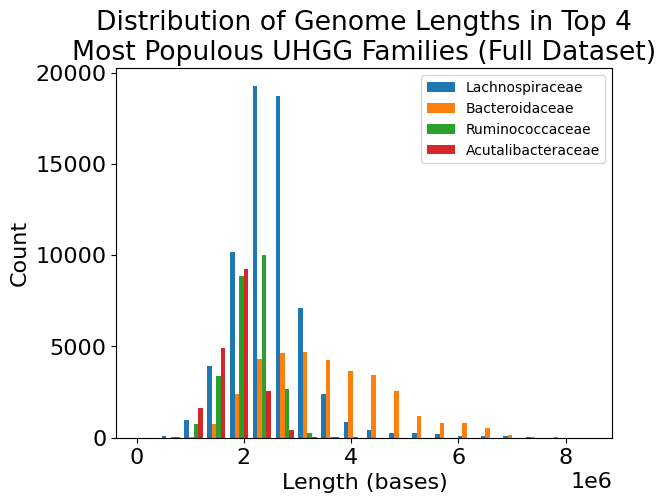

In [16]:
plt.rcParams.update({'font.size': 16})
plt.hist(list(len_dict.values()), label=list(len_dict.keys()), bins=20)
plt.title("Distribution of Genome Lengths in Top 4\nMost Populous UHGG Families (Full Dataset)")
plt.xlabel("Length (bases)")
plt.ylabel('Count')
plt.legend(fontsize=10)

In [13]:
import random
sample_array = [random.sample(len_list, len(list(len_dict.values())[3])) for len_list in len_dict.values()]


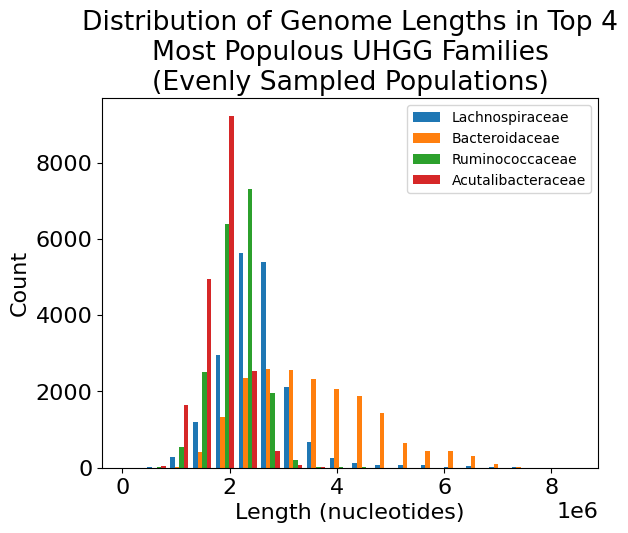

In [17]:
plt.rcParams.update({'font.size': 16})

plt.hist(sample_array, label=list(len_dict.keys()), bins=20)
plt.title("Distribution of Genome Lengths in Top 4\nMost Populous UHGG Families\n(Evenly Sampled Populations)")
plt.xlabel("Length (nucleotides)")
plt.ylabel('Count')
plt.legend(fontsize="10")

In [36]:
import gzip
import numpy as np
import time
ints = np.array(list(np.random.randint(0, 8192000, [1006963])))
print(ints.shape)
start_time = time.time()
print(type(gzip.compress(ints)))
# print(f"time to compress rand ints: {time.time()-start_time}")
# string = "".join([np.random.choice(["A", "T", "G", "C"]) for i in range(10069630)])
# start_time=time.time()
# print(len(gzip.compress(string.encode())))
# print(f"time to compress rand string: {time.time()-start_time}")


(1006963,)
<class 'bytes'>
